In [1]:
import numpy as np
import pandas as pd

# maps
import geopandas as gpd
from geopandas import GeoDataFrame
import polyline
from shapely.geometry import Point, LineString, MultiLineString

# plot
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy
from collections import Counter
%matplotlib inline
sns.set_style("darkgrid")

In [2]:
traffic = pd.read_csv("DOT_Traffic_Speeds_NBE.csv")

## To Figure Out

- Where is each link?
- What congressional distrrict is the link in
- how many wrecks were in each congressional district?
- What is the speed limit?
- Is there construction happening?

In [3]:
traffic.head()

,ID,SPEED,TRAVEL_TIME,STATUS,DATA_AS_OF,LINK_ID,LINK_POINTS,ENCODED_POLY_LINE,ENCODED_POLY_LINE_LVLS,OWNER,TRANSCOM_ID,BOROUGH,LINK_NAME
0,369,0.00,0,-101,04/17/2019 09:38:13 AM,4616282,"40.65632,-74.11972 40.655041,-74.12241 40.6544...",_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,BBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,4616282,Staten Island,ROUTE 169 S - MLK WALKER STREET
1,422,31.06,285,0,04/17/2019 09:38:13 AM,4616298,"40.7278806,-73.832761 40.7270705,-73.83231 40....",gtqwFvmsaM`DyAnBoA~AeBzF{J`B_C`BgBhBaB~CoBdBaA...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,4616298,Queens,VWE N MP4.63 (Exit 6 - Jamaica Ave) - MP6.39 (...
2,423,31.06,170,0,04/17/2019 09:38:13 AM,4616299,"40.7624804,-73.839391 40.76191,-73.839121 40.7...",olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,4616299,Queens,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...
3,354,59.03,138,0,04/17/2019 09:38:13 AM,4616228,"40.8859405,-73.89676 40.88698,-73.89528 40.887...",cppxFv}_bMoEgH_CqFeD{LsCqPqBeGeEaGeRiRoP{OuFeD...,BBBBBBBBBBBBBBBB,NYC_DOT_LIC,4616228,Bronx,I-87 NYST S Exit 1 - MDE S Van Cortlandt Park
4,204,49.08,237,0,04/17/2019 09:38:13 AM,4616320,"40.7894406,-73.786291 40.78918,-73.78792 40....",_u}wFhkjaMr@dI~A~HtA|EbEnKxBdHv@~Cv@jGRhCJ~G[p...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,4616320,Queens,CIP N TNB - Whitestone Expwy S Exit 14 (Linden...


In [4]:
traffic.dtypes

ID                          int64
SPEED                     float64
TRAVEL_TIME                 int64
STATUS                      int64
DATA_AS_OF                 object
LINK_ID                     int64
LINK_POINTS                object
ENCODED_POLY_LINE          object
ENCODED_POLY_LINE_LVLS     object
OWNER                      object
TRANSCOM_ID                 int64
BOROUGH                    object
LINK_NAME                  object
dtype: object

In [5]:
traffic['DATA_AS_OF'] = pd.to_datetime(traffic['DATA_AS_OF'])

In [6]:
traffic.dtypes

ID                                 int64
SPEED                            float64
TRAVEL_TIME                        int64
STATUS                             int64
DATA_AS_OF                datetime64[ns]
LINK_ID                            int64
LINK_POINTS                       object
ENCODED_POLY_LINE                 object
ENCODED_POLY_LINE_LVLS            object
OWNER                             object
TRANSCOM_ID                        int64
BOROUGH                           object
LINK_NAME                         object
dtype: object

In [7]:
traffic['year'] = traffic['DATA_AS_OF'].dt.year
traffic['month'] = traffic['DATA_AS_OF'].dt.month
traffic['dayofweek'] = traffic['DATA_AS_OF'].dt.dayofweek
traffic['RecordedAtTime'] = traffic['DATA_AS_OF'].dt.time
traffic['hour'] = traffic['DATA_AS_OF'].dt.hour
traffic['minute'] = traffic['DATA_AS_OF'].dt.minute

In [8]:
traffic['year'].value_counts()

2018    13860107
2017     6019989
2019     3885370
2016          36
1978          15
2015           9
1930           8
2014           6
Name: year, dtype: int64

In [9]:
traffic_18 = traffic.loc[traffic['year'] == 2018]

In [10]:
traffic_18['month'].value_counts()

12    1202431
7     1197504
1     1195225
3     1193919
10    1164869
6     1158362
9     1154990
11    1147329
4     1135775
5     1120624
8     1108600
2     1080479
Name: month, dtype: int64

In [11]:
traffic_18['STATUS'].value_counts()

 0      11891589
-101     1968518
Name: STATUS, dtype: int64

In [12]:
traffic_18.dtypes

ID                                 int64
SPEED                            float64
TRAVEL_TIME                        int64
STATUS                             int64
DATA_AS_OF                datetime64[ns]
LINK_ID                            int64
LINK_POINTS                       object
ENCODED_POLY_LINE                 object
ENCODED_POLY_LINE_LVLS            object
OWNER                             object
TRANSCOM_ID                        int64
BOROUGH                           object
LINK_NAME                         object
year                               int64
month                              int64
dayofweek                          int64
RecordedAtTime                    object
hour                               int64
minute                             int64
dtype: object

In [13]:
traffic_18.describe()

,ID,SPEED,TRAVEL_TIME,STATUS,LINK_ID,TRANSCOM_ID,year,month,dayofweek,hour,minute
count,1.386011e+07,1.386011e+07,1.386011e+07,1.386011e+07,1.386011e+07,1.386011e+07,13860107.0,1.386011e+07,1.386011e+07,1.386011e+07,1.386011e+07
mean,2.913240e+02,3.451621e+01,2.019082e+02,-1.434479e+01,4.575028e+06,4.575028e+06,2018.0,6.520805e+00,2.981954e+00,1.150069e+01,3.036628e+01
std,1.187646e+02,1.964891e+01,3.151803e+02,3.525693e+01,1.030490e+05,1.030490e+05,0.0,3.465477e+00,1.993173e+00,6.929722e+00,1.727227e+01
min,1.000000e+00,0.000000e+00,-6.000000e+01,-1.010000e+02,4.329472e+06,4.329472e+06,2018.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.850000e+02,1.801000e+01,6.400000e+01,0.000000e+00,4.616192e+06,4.616192e+06,2018.0,3.000000e+00,1.000000e+00,5.000000e+00,1.700000e+01
50%,3.240000e+02,4.101000e+01,1.290000e+02,0.000000e+00,4.616235e+06,4.616235e+06,2018.0,7.000000e+00,3.000000e+00,1.100000e+01,3.200000e+01
75%,3.990000e+02,5.095000e+01,2.340000e+02,0.000000e+00,4.616332e+06,4.616332e+06,2018.0,1.000000e+01,5.000000e+00,1.800000e+01,4.600000e+01
max,4.530000e+02,1.180600e+02,1.023000e+04,0.000000e+00,4.763657e+06,4.763657e+06,2018.0,1.200000e+01,6.000000e+00,2.300000e+01,5.900000e+01


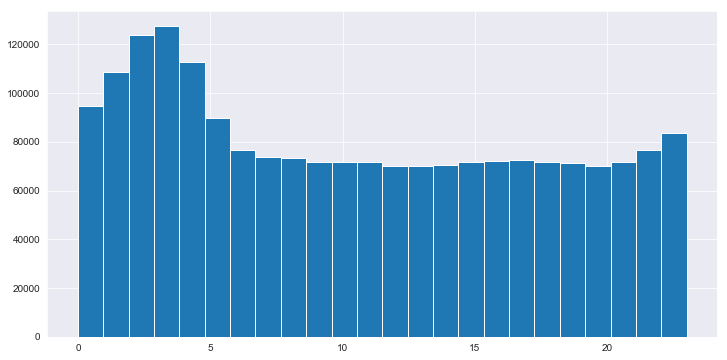

In [14]:
plt.figure(figsize=(12,6))
plt.hist(traffic_18['hour'].loc[traffic_18['STATUS']==-101], bins=24)
plt.show()

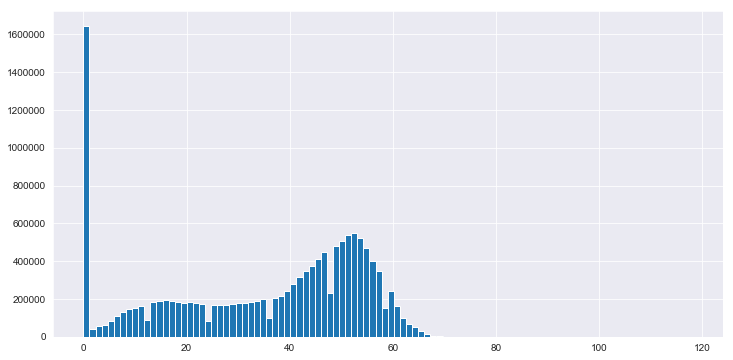

In [15]:
plt.figure(figsize=(12,6))
plt.hist(traffic_18['SPEED'], bins=100)
plt.show()

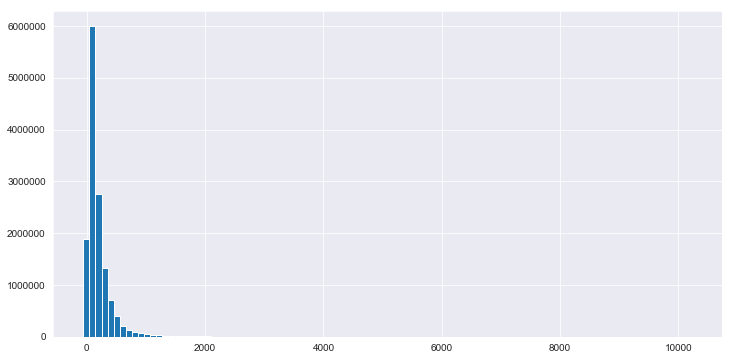

In [16]:
plt.figure(figsize=(12,6))
plt.hist(traffic_18['TRAVEL_TIME'], bins=100)
plt.show()

In [17]:
traffic_18['STATUS'].value_counts()

 0      11891589
-101     1968518
Name: STATUS, dtype: int64

In [18]:
traffic_18.head()

,ID,SPEED,TRAVEL_TIME,STATUS,DATA_AS_OF,LINK_ID,LINK_POINTS,ENCODED_POLY_LINE,ENCODED_POLY_LINE_LVLS,OWNER,TRANSCOM_ID,BOROUGH,LINK_NAME,year,month,dayofweek,RecordedAtTime,hour,minute
3885370,369,0.00,0,-101,2018-12-31 23:58:23,4616282,"40.65632,-74.11972 40.655041,-74.12241 40.6544...",_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,BBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,4616282,Staten Island,ROUTE 169 S - MLK WALKER STREET,2018,12,0,23:58:23,23,58
3885371,423,47.22,113,0,2018-12-31 23:58:23,4616299,"40.7624804,-73.839391 40.76191,-73.839121 40.7...",olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,4616299,Queens,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,2018,12,0,23:58:23,23,58
3885372,424,47.22,112,0,2018-12-31 23:58:23,4616300,"40.77125,-73.833351 40.77065,-73.834421 40.770...",iczwFlqsaMvBtEtBbEnChEvBfBxCdCnCjAjGtD`AZpBbAj...,BBBBBBBBBBBBBBBB,NYC_DOT_LIC,4616300,Queens,VWE N MP8.64 (Exit 13 Northern Blvd) - Whitest...,2018,12,0,23:58:23,23,58
3885373,165,2.48,847,-101,2018-12-31 23:58:23,4616305,"40.81477,-73.83629 40.81611,-73.83627 40.81784...",isbxFxctaMkGCyIs@_NWgVb@iF`@,BBBBBB,NYC_DOT_LIC,4616305,Bronx,BWB N Toll Plaza - HRP N Lafayatte Ave,2018,12,0,23:58:23,23,58
3885374,257,38.52,328,0,2018-12-31 23:58:23,4616318,"40.6333906,-74.01586 40.634,-74.015921 40.6344...",ue_wFbfwbMyBJyAX_Bp@oBhBiD|FmGxL_BzBuAbAoBv@mB...,BBBBBBBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,4616318,Brooklyn,GOW N 7TH AVENUE - 9TH STREET,2018,12,0,23:58:23,23,58


In [19]:
traffic_18['LINK_NAME'].value_counts()

11th ave n ganservoort - 12th ave @ 40th st                        103069
12th Ave S 57th St - 45th St                                       103068
440 N FRANCIS STREET - WSE N TYRELLAN AVE                          103067
BE S Griswold - Castle Hill Avenue                                 103063
BE N STRATFORD AVENUE - CASTLE HILL AVE                            103063
BE S CASTLE HILL AVENUE - STRATFORD AVENUE                         103063
BE N Castle Hill Avenue - Griswold Ave                             103063
BQE N Atlantic Ave - MAN Bridge Manhattan Side                     103062
BKN Bridge Manhattan Side - FDR N Catherine Slip                   103062
BQE S - GOW S ALTANTIC AVENUE - 9TH STREET                         103062
BQE N Atlantic Ave - BKN Bridge Manhattan Side                     103062
BQE S 46TH STREET - LEONARD STREET                                 103062
BRP N WATSON AVENUE - FORDHAM ROAD                                 103061
BQE N LEONARD STREET - 46TH STREET    

In [20]:
traffic_18 = traffic_18.reset_index()

In [21]:
traffic_18['LINK_POINTS'][0]

'40.65632,-74.11972 40.655041,-74.12241 40.6544106,-74.124361 40.6541206,-74.125881 40.654011,-74.127141 40.65429,-74.13302 40.6542505,-74.133981 40.65404,-74.134611 40.6535805,-74.135461 40.6533,-74.135771 40.64786,-74.13964 40.64705,-74.140071 40.6444705'

In [22]:
print(traffic_18['ENCODED_POLY_LINE'][0])
polyline.decode(traffic_18['ENCODED_POLY_LINE'][0])

_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~`@dW`DtAbObFv]rKpUhHfFvAtMtBfH`@


[(40.65632, -74.11972),
 (40.65504, -74.12241),
 (40.65441, -74.12436),
 (40.65412, -74.12588),
 (40.65401, -74.12714),
 (40.65429, -74.13302),
 (40.65425, -74.13398),
 (40.65404, -74.13461),
 (40.65358, -74.13546),
 (40.6533, -74.13577),
 (40.64786, -74.13964),
 (40.64705, -74.14007),
 (40.64447, -74.14121),
 (40.63955, -74.14323),
 (40.63594, -74.14472),
 (40.63478, -74.14516),
 (40.63243, -74.14575),
 (40.63095, -74.14592)]

In [23]:
traffic_18.columns

Index(['index', 'ID', 'SPEED', 'TRAVEL_TIME', 'STATUS', 'DATA_AS_OF',
       'LINK_ID', 'LINK_POINTS', 'ENCODED_POLY_LINE', 'ENCODED_POLY_LINE_LVLS',
       'OWNER', 'TRANSCOM_ID', 'BOROUGH', 'LINK_NAME', 'year', 'month',
       'dayofweek', 'RecordedAtTime', 'hour', 'minute'],
      dtype='object')

In [24]:
links = traffic_18[['LINK_ID','LINK_NAME','ENCODED_POLY_LINE']].drop_duplicates()

links = links.reset_index(drop=True)
links = links.drop([51,73])
links = links.reset_index(drop=True)

links

,LINK_ID,LINK_NAME,ENCODED_POLY_LINE
0,4616282,ROUTE 169 S - MLK WALKER STREET,_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...
1,4616299,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...
2,4616300,VWE N MP8.64 (Exit 13 Northern Blvd) - Whitest...,iczwFlqsaMvBtEtBbEnChEvBfBxCdCnCjAjGtD`AZpBbAj...
3,4616305,BWB N Toll Plaza - HRP N Lafayatte Ave,isbxFxctaMkGCyIs@_NWgVb@iF`@
4,4616318,GOW N 7TH AVENUE - 9TH STREET,ue_wFbfwbMyBJyAX_Bp@oBhBiD|FmGxL_BzBuAbAoBv@mB...
5,4616319,GOW S 9TH STREET - 7TH AVENUE,ud_wF|gwbMgCCwATcBr@_BvAqDhGmGtL{AxB}AlAsBt@uB...
6,4616320,CIP N TNB - Whitestone Expwy S Exit 14 (Linden...,_u}wFhkjaMr@dI~A~HtA|EbEnKxBdHv@~Cv@jGRhCJ~G[p...
7,4616324,12th ave @ 45th - 11 ave ganservoort st,mtxwF|}sbMl@^~GpK|LrIbLlH??lK~G|FtD`C~@}@WdWnG...
8,4616325,11th ave s ganservoort - west st @ spring st,y{swFvavbMjANlGSvQn@fa@fBhQdA
9,4616329,FDR N 25th - 63rd St,slswFpdobMcJ{Fy@_@sBq@kKeBaDc@eB_@iBs@kC{AuBkA...


In [25]:
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

links['GEOMETRY'] = links['ENCODED_POLY_LINE'].progress_apply(lambda x: polyline.decode(x))

links

#points = pd.DataFrame()

#for i in range(len(links)):
#    point = polyline.decode(links['ENCODED_POLY_LINE'][i])
#    points = points.append([point])

#points

100%|██████████| 134/134 [00:00<00:00, 14352.68it/s]


,LINK_ID,LINK_NAME,ENCODED_POLY_LINE,GEOMETRY
0,4616282,ROUTE 169 S - MLK WALKER STREET,_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,"[(40.65632, -74.11972), (40.65504, -74.12241),..."
1,4616299,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,"[(40.76248, -73.83939), (40.76191, -73.83912),..."
2,4616300,VWE N MP8.64 (Exit 13 Northern Blvd) - Whitest...,iczwFlqsaMvBtEtBbEnChEvBfBxCdCnCjAjGtD`AZpBbAj...,"[(40.77125, -73.83335), (40.77065, -73.83442),..."
3,4616305,BWB N Toll Plaza - HRP N Lafayatte Ave,isbxFxctaMkGCyIs@_NWgVb@iF`@,"[(40.81477, -73.83629), (40.81611, -73.83627),..."
4,4616318,GOW N 7TH AVENUE - 9TH STREET,ue_wFbfwbMyBJyAX_Bp@oBhBiD|FmGxL_BzBuAbAoBv@mB...,"[(40.63339, -74.01586), (40.634, -74.01592), (..."
5,4616319,GOW S 9TH STREET - 7TH AVENUE,ud_wF|gwbMgCCwATcBr@_BvAqDhGmGtL{AxB}AlAsBt@uB...,"[(40.63323, -74.01615), (40.63391, -74.01613),..."
6,4616320,CIP N TNB - Whitestone Expwy S Exit 14 (Linden...,_u}wFhkjaMr@dI~A~HtA|EbEnKxBdHv@~Cv@jGRhCJ~G[p...,"[(40.78944, -73.78629), (40.78918, -73.78792),..."
7,4616324,12th ave @ 45th - 11 ave ganservoort st,mtxwF|}sbMl@^~GpK|LrIbLlH??lK~G|FtD`C~@}@WdWnG...,"[(40.76375, -73.99919), (40.76352, -73.99935),..."
8,4616325,11th ave s ganservoort - west st @ spring st,y{swFvavbMjANlGSvQn@fa@fBhQdA,"[(40.73933, -74.01004), (40.73895, -74.01012),..."
9,4616329,FDR N 25th - 63rd St,slswFpdobMcJ{Fy@_@sBq@kKeBaDc@eB_@iBs@kC{AuBkA...,"[(40.7369, -73.97465), (40.73868, -73.97339), ..."


In [26]:
# geocode
import math
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="specify_your_app_name_here")
location_1 = geolocator.reverse(links['GEOMETRY'][0][0])
location_2 = geolocator.reverse(links['GEOMETRY'][0][-1])

print(links['LINK_NAME'][0])
print(location_1)
print(location_2)

ROUTE 169 S - MLK WALKER STREET
NJ 440, Bayonne, Hudson County, New Jersey, 07002, USA
Walker Street, Elm Park, Staten Island, Richmond County, NYC, New York, 10303, USA


In [27]:
geolocator = Nominatim(user_agent="Thinkful-Capstone")
location_1 = geolocator.reverse(links['GEOMETRY'][1][0])
location_2 = geolocator.reverse(links['GEOMETRY'][1][-1])

print(links['LINK_NAME'][1])
print(location_1)
print(location_2)

VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exit 13 Northern Blvd)
Northern Boulevard, East Elmhurst, Queens, Queens County, NYC, New York, 11354, USA
Van Wyck Expressway, Kew Gardens, Queens, Queens County, NYC, New York, 11367, USA


In [29]:
links['LINK_START'] = links['GEOMETRY'].progress_apply(lambda x: geolocator.reverse(x[0]))
links['LINK_END'] = links['GEOMETRY'].progress_apply(lambda x: geolocator.reverse(x[-1]))
links['LINK_MIDDLE'] = links['GEOMETRY'].progress_apply(lambda x: geolocator.reverse(x[len(x)//2]))


 17%|█▋        | 23/134 [00:11<00:55,  2.01it/s]


 34%|███▍      | 46/134 [00:23<00:39,  2.23it/s]


100%|██████████| 134/134 [01:06<00:00,  1.85it/s]

In [30]:
links.tail(60)

,LINK_ID,LINK_NAME,ENCODED_POLY_LINE,GEOMETRY,LINK_START,LINK_END,LINK_MIDDLE
74,4616229,BQE S - GOW S ALTANTIC AVENUE - 9TH STREET,kngwFzjtbM{CjBiIzG}Ap@yBXeACuA[uBw@uDuAqVoJgK{...,"[(40.67574, -74.00126), (40.67652, -74.0018), ...","(310, Hamilton Avenue, Carroll Gardens, Kings ...","(Brooklyn-Queens Expressway, Cobble Hill, King...","(Brooklyn-Queens Expressway, Cobble Hill, King..."
75,4616223,GOW N 9TH STREET - ATLANTIC AVENUE,omgwFfhtbMeDnAaDbB_F|CqDzC_ARwAQqBy@qDuAmVoJkK...,"[(40.6756, -74.00084), (40.67643, -74.00124), ...","(Gowanus Expressway, Carroll Gardens, Kings Co...","(Brooklyn-Queens Expressway, Cobble Hill, King...","(Brooklyn-Queens Expressway, Columbia Street W..."
76,4616219,VNB E-GOWANUS N BROOKLYN GANTRY UPPER LEVEL - ...,uhzvFjx{bM}J{c@aB{HkCqHqAqBaG}DaEoCwLsJ,"[(40.60827, -74.03926), (40.61018, -74.03336),...","(Verrazzano-Narrows Bridge, Fort Hamilton, Kin...","(92nd Street, Fort Hamilton, Kings County, NYC...","(Gowanus Expressway, Fort Hamilton, Kings Coun..."
77,4616218,VNB E-GOWANUS N BROOKLYN GANTRY LOWER LEVEL - ...,ahzvFjx{bM_Kyc@cBaI{BgHcBgC{F_EyDaDkMiJ,"[(40.60817, -74.03926), (40.61009, -74.03337),...","(Verrazzano-Narrows Bridge, Fort Hamilton, Kin...","(92nd Street, Fort Hamilton, Kings County, NYC...","(Gowanus Expressway, Fort Hamilton, Kings Coun..."
78,4616215,WSE N TYRELLAN AVENUE - BLOOMINGDALE ROAD,adjvF|badMs@iYaBsPcEB_|@vDyLWeHg@mUeF}L}EuIaF,"[(40.52561, -74.23039), (40.52587, -74.22618),...","(101, Tyrellan Avenue, Richmond Valley, Richmo...","(Bloomingdale Road, Rossville, Richmond County...","(West Shore Expressway, Charleston, Richmond C..."
79,4616214,WSE N BLOOMUINGDALE ROAD - ARDEN AVENUE,s}pvFda{cMjFpGpCvExBrFlCdJ`Fb[`AzEjBbHtCxHtCfG...,"[(40.56042, -74.19939), (40.55924, -74.20076),...","(West Shore Expressway, Rossville, Richmond Co...","(Bloomingdale Road, Rossville, Richmond County...","(West Shore Expressway, Rossville, Richmond Co..."
80,4616213,WSE N ARDEN AVENUE - VICTORY BLVD,wwvvFf{ycMnnA{PxFw@tKkApIBpD^`GpA~NbI`m@fm@,"[(40.5902, -74.19332), (40.57748, -74.19046), ...","(West Shore Expressway, Travis, Staten Island,...","(2, Arden Avenue, Fresh Kills, Richmond County...","(West Shore Expressway, Fresh Kills, Staten Is..."
81,4616212,WSE N VICTORY BLVD - SOUTH AVENUE,abyvFbxxcM~IxIrNvH~b@jLhGf@jBA,"[(40.60209, -74.1877), (40.60033, -74.18943), ...","(South Avenue, Chelsea, Staten Island, Richmon...","(West Shore Expressway, Travis, Staten Island,...","(West Shore Expressway, Travis, Staten Island,..."
82,4616211,SIE W RICHMOND AVENUE - SOUTH AVENUE,ys{vFrzrcM{LzRuRdf@sAvEQv@[lB,"[(40.61517, -74.15738), (40.61739, -74.16056),...","(Staten Island Expressway, Bulls Head, Staten ...","(South Avenue, Arlington, Staten Island, Richm...","(Staten Island Expressway, Bulls Head, Staten ..."
83,4616209,SIE W WOOLEY AVENUE - RICHMOND AVENUE,at{vFvzrcMbQsVlP{UjCkFbBsFxAkJ\{HKiS,"[(40.61521, -74.1574), (40.61231, -74.15362), ...","(Staten Island Expressway, Bulls Head, Staten ...","(Staten Island Expressway, Castleton Corners, ...","(Staten Island Expressway, Castleton Corners, ..."


In [31]:
links.iloc[5]

LINK_ID                                                        4616319
LINK_NAME                                GOW S 9TH STREET - 7TH AVENUE
ENCODED_POLY_LINE    ud_wF|gwbMgCCwATcBr@_BvAqDhGmGtL{AxB}AlAsBt@uB...
GEOMETRY             [(40.63323, -74.01615), (40.63391, -74.01613),...
LINK_START           (Gowanus Expressway, Bay Ridge, Kings County, ...
LINK_END             (310, Hamilton Avenue, Carroll Gardens, Kings ...
LINK_MIDDLE          (6100, Gowanus Expressway, Bay Ridge, Kings Co...
Name: 5, dtype: object

In [32]:
print(links['LINK_START'][5].raw['address']['road'])
print(links['LINK_MIDDLE'][5].raw['address']['road'])
print(links['LINK_END'][5].raw['address']['road'])

Gowanus Expressway
Gowanus Expressway
Hamilton Avenue


In [33]:
links['LINK_START'][13].raw

{'place_id': 151531789,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 328876884,
 'lat': '40.7136335',
 'lon': '-73.7285538294495',
 'display_name': 'Belmont, Cross Island Parkway, Elmont, Queens County, NYC, New York, 11411, USA',
 'address': {'platform': 'Belmont',
  'road': 'Cross Island Parkway',
  'locality': 'Elmont',
  'county': 'Queens County',
  'city': 'NYC',
  'state': 'New York',
  'postcode': '11411',
  'country': 'USA',
  'country_code': 'us'},
 'boundingbox': ['40.7125609', '40.7147487', '-73.7287191', '-73.7282479']}

In [34]:
start = []
middle = []
end = []

for i in range(len(links)):
    if 'road' not in links['LINK_START'][i].raw['address']:
        start.append(None)
    else:
        start.append(links['LINK_START'][i].raw['address']['road'])
        
for i in range(len(links)):
    if 'road' not in links['LINK_MIDDLE'][i].raw['address']:
        middle.append(None)
    else:
        middle.append(links['LINK_MIDDLE'][i].raw['address']['road'])
        
for i in range(len(links)):
    if 'road' not in links['LINK_END'][i].raw['address']:
        end.append(None)
    else:
        end.append(links['LINK_END'][i].raw['address']['road'])
    
links['START_ROAD'] = start
links['MIDDLE_ROAD'] = middle
links['END_ROAD'] = end

In [35]:
links['START_ROAD'][0]

'NJ 440'

In [36]:
# Get the most common road among the

road = []

for i in range(len(links)):
    if links['START_ROAD'][i] == links['MIDDLE_ROAD'][i]:
        road.append(links['START_ROAD'][i])
    elif links['START_ROAD'][i] == links['END_ROAD'][i]:
        road.append(links['START_ROAD'][i])
    elif links['END_ROAD'][i] == links['MIDDLE_ROAD'][i]:
        road.append(links['END_ROAD'][i])
    else:
        road.append(None)

links['ROAD'] = road        

road

['NJ 440',
 'Van Wyck Expressway',
 None,
 'Hutchinson River Expressway',
 'Gowanus Expressway',
 'Gowanus Expressway',
 None,
 '12th Avenue',
 'West Street',
 'FDR Drive',
 'FDR Drive',
 '12th Avenue',
 None,
 'Cross Island Parkway',
 'Cross Island Parkway',
 'Cross Island Parkway',
 'Belt Parkway',
 'Van Wyck Expressway',
 'Cross Island Parkway',
 None,
 'NJ 440',
 None,
 None,
 'Dr. Martin Luther King Jr. Expressway',
 None,
 'Gowanus Expressway',
 None,
 'Gowanus Expressway',
 'Major Deegan Expressway',
 None,
 '12th Avenue',
 None,
 'Bruckner Expressway',
 'Bruckner Expressway',
 'Hutchinson River Parkway',
 'Bronx River Parkway',
 'Bruckner Expressway',
 'Bruckner Expressway',
 None,
 None,
 'Henry Hudson Parkway',
 None,
 None,
 'Lincoln Tunnel',
 None,
 'Lincoln Tunnel',
 'Lincoln Tunnel',
 'Major Deegan Expressway',
 None,
 'Major Deegan Expressway',
 None,
 'Long Island Expressway',
 'Belt Parkway',
 'Belt Parkway',
 'Henry Hudson Parkway',
 'FDR Drive',
 None,
 None,
 'Brook

In [37]:
links.head(2)

,LINK_ID,LINK_NAME,ENCODED_POLY_LINE,GEOMETRY,LINK_START,LINK_END,LINK_MIDDLE,START_ROAD,MIDDLE_ROAD,END_ROAD,ROAD
0,4616282,ROUTE 169 S - MLK WALKER STREET,_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,"[(40.65632, -74.11972), (40.65504, -74.12241),...","(NJ 440, Bayonne, Hudson County, New Jersey, 0...","(Walker Street, Elm Park, Staten Island, Richm...","(NJ 440, Bayonne, Hudson County, New Jersey, 0...",NJ 440,NJ 440,Walker Street,NJ 440
1,4616299,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,"[(40.76248, -73.83939), (40.76191, -73.83912),...","(Northern Boulevard, East Elmhurst, Queens, Qu...","(Van Wyck Expressway, Kew Gardens, Queens, Que...","(Van Wyck Expressway, Queens, Queens County, N...",Northern Boulevard,Van Wyck Expressway,Van Wyck Expressway,Van Wyck Expressway


In [38]:
links[['LINK_NAME','START_ROAD','MIDDLE_ROAD','END_ROAD','ROAD']].loc[links['ROAD'].isnull()]

,LINK_NAME,START_ROAD,MIDDLE_ROAD,END_ROAD,ROAD
2,VWE N MP8.64 (Exit 13 Northern Blvd) - Whitest...,Linden Place,Van Wyck Expressway,Northern Boulevard,None
6,CIP N TNB - Whitestone Expwy S Exit 14 (Linden...,Cross Island Parkway,Cross Island Parkway Westbound,Linden Place,None
12,12th Ave N 40th - 57th St,None,West 50th Street,12th Avenue,None
19,LINCOLN TUNNEL E CENTER TUBE NJ - NY,10th Avenue,Lincoln Tunnel,None,None
21,MLK S - SIE E WALKER STREET - WOOLEY AVENUE,Walker Street,Dr. Martin Luther King Jr. Expressway,Staten Island Expressway,None
22,MLK S - SIE W WALKER STREET - RICHMOND AVENUE,Walker Street,Dr. Martin Luther King Jr. Expressway,Staten Island Expressway,None
24,SIE W - MLK N WOOLEY AVENUE - WLAKER STREET,Dr. Martin Luther King Jr. Expressway,Willow Road East,Staten Island Expressway,None
26,TBB N QUEENS ANCHORAGE - BE N,Grand Central Parkway,Robert F. Kennedy Bridge Southbound,Bruckner Expressway,None
29,Whitestone Expwy S Exit 14 (Linden Pl) - VWE S...,Linden Place,Van Wyck Expressway,Northern Boulevard,None
31,VWE S MP8.65 (Exit 13 Northern Blvd) - MP6.39 ...,Northern Boulevard,Van Wyck Expressway,69th Road,None


In [39]:
to_middle = [2,19,21,22,26,29,31,39,42,48,50,62,63,78,89,92,100,101,102,103,104,110,112,116,117,120,121,125,132,133]
to_start = [6,56,57,66,67,76,77,86,87,88,99,106,107,115,130,131]
to_end = [12,24,38,72,73,113,127]

links['ROAD'][to_middle] = links['MIDDLE_ROAD'][to_middle]
links['ROAD'][to_start] = links['START_ROAD'][to_start]
links['ROAD'][to_end] = links['END_ROAD'][to_end]

#leftovers
links['ROAD'][41] = 'Cross Bronx Expressway'
links['ROAD'][44] = 'Whitestone Expressway'
links['ROAD'][124,128] = 'Robert F. Kennedy Bridge'

links['ROAD']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

0                                                 NJ 440
1                                    Van Wyck Expressway
2                                    Van Wyck Expressway
3                            Hutchinson River Expressway
4                                     Gowanus Expressway
5                                     Gowanus Expressway
6                                   Cross Island Parkway
7                                            12th Avenue
8                                            West Street
9                                              FDR Drive
10                                             FDR Drive
11                                           12th Avenue
12                                           12th Avenue
13                                  Cross Island Parkway
14                                  Cross Island Parkway
15                                  Cross Island Parkway
16                                          Belt Parkway
17                             

In [40]:
links['MIDDLE_ROAD'][to_middle]

2                         Van Wyck Expressway
19                             Lincoln Tunnel
21      Dr. Martin Luther King Jr. Expressway
22      Dr. Martin Luther King Jr. Expressway
26        Robert F. Kennedy Bridge Southbound
29                        Van Wyck Expressway
31                        Van Wyck Expressway
39     George Washington Bridge (upper level)
42                     Cross Bronx Expressway
48     George Washington Bridge (upper level)
50     George Washington Bridge (upper level)
62                     Cross Bronx Expressway
63                     Cross Bronx Expressway
78                      West Shore Expressway
89                      West Shore Expressway
92                   Staten Island Expressway
100                      Cross Island Parkway
101                    Long Island Expressway
102                      Cross Island Parkway
103       Robert F. Kennedy Bridge Southbound
104       Robert F. Kennedy Bridge Southbound
110                        Gowanus

In [41]:
geolocator.reverse(links['GEOMETRY'][1][(len(links['GEOMETRY'][1])//2)])

Location(Van Wyck Expressway, Queens, Queens County, NYC, New York, 11355, USA, (40.7480381243209, -73.8347012549507, 0.0))

___

In [42]:
traffic_18['ENCODED_POLY_LINE_LVLS'].value_counts()

BBBBBBBBBBBBBBB                                                     1025607
BBBBBBB                                                              926217
BBBBBBBBBBBBBB                                                       822825
BBBBBBBBBB                                                           822588
BBBBBBBBB                                                            821257
BBBBBBBBBBBBB                                                        819803
BBBBBB                                                               720051
BBBBBBBB                                                             711783
BBBBBBBBBBBBBBBB                                                     616800
BBBBBBBBBBBBBBBBBBBBBBBBB                                            614809
BBBBB                                                                511234
BBBB                                                                 411171
BBBBBBBBBBBBBBBBBBB                                                  410934
BBBBBBBBBBBB

In [43]:
traffic_18['poly_num'] = traffic_18['ENCODED_POLY_LINE_LVLS'].astype('str').str.len()

In [44]:
traffic_18['poly_num'].value_counts()

15    1025607
7      926217
14     822825
10     822588
9      821257
13     819803
6      720051
8      711783
16     616800
25     614809
5      511234
4      411171
19     410934
24     309174
30     308914
26     308603
11     307881
23     307879
34     307872
33     206114
2      206112
37     206076
21     205844
28     205743
55     205390
17     103068
18     103056
27     103055
44     103055
42     103055
64     103049
12     103048
38     102841
53     102799
61     102798
41     102288
47     102045
20     101764
31     101755
29     101750
Name: poly_num, dtype: int64

In [45]:
traffic_18.head()

,index,ID,SPEED,TRAVEL_TIME,STATUS,DATA_AS_OF,LINK_ID,LINK_POINTS,ENCODED_POLY_LINE,ENCODED_POLY_LINE_LVLS,...,TRANSCOM_ID,BOROUGH,LINK_NAME,year,month,dayofweek,RecordedAtTime,hour,minute,poly_num
0,3885370,369,0.00,0,-101,2018-12-31 23:58:23,4616282,"40.65632,-74.11972 40.655041,-74.12241 40.6544...",_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,BBBBBBBBBBBBBBBBBB,...,4616282,Staten Island,ROUTE 169 S - MLK WALKER STREET,2018,12,0,23:58:23,23,58,18
1,3885371,423,47.22,113,0,2018-12-31 23:58:23,4616299,"40.7624804,-73.839391 40.76191,-73.839121 40.7...",olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,...,4616299,Queens,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,2018,12,0,23:58:23,23,58,44
2,3885372,424,47.22,112,0,2018-12-31 23:58:23,4616300,"40.77125,-73.833351 40.77065,-73.834421 40.770...",iczwFlqsaMvBtEtBbEnChEvBfBxCdCnCjAjGtD`AZpBbAj...,BBBBBBBBBBBBBBBB,...,4616300,Queens,VWE N MP8.64 (Exit 13 Northern Blvd) - Whitest...,2018,12,0,23:58:23,23,58,16
3,3885373,165,2.48,847,-101,2018-12-31 23:58:23,4616305,"40.81477,-73.83629 40.81611,-73.83627 40.81784...",isbxFxctaMkGCyIs@_NWgVb@iF`@,BBBBBB,...,4616305,Bronx,BWB N Toll Plaza - HRP N Lafayatte Ave,2018,12,0,23:58:23,23,58,6
4,3885374,257,38.52,328,0,2018-12-31 23:58:23,4616318,"40.6333906,-74.01586 40.634,-74.015921 40.6344...",ue_wFbfwbMyBJyAX_Bp@oBhBiD|FmGxL_BzBuAbAoBv@mB...,BBBBBBBBBBBBBBBBBBBBBBBBBBBB,...,4616318,Brooklyn,GOW N 7TH AVENUE - 9TH STREET,2018,12,0,23:58:23,23,58,28


___

In [46]:
sp_limits = pd.read_csv('dot_VZV_Speed_Limits_20190401.csv')

sp_limits_gpd = gpd.read_file('VZV_Speed Limits.geojson')

sp_limits_gpd.head()

,postvz_sg,postvz_sl,shape_leng,street,geometry
0,NO,25,55.3930487335,WEST ROAD,(LINESTRING (-73.95165916730909 40.76029515311...
1,NO,0,179.30712293,HARLEM RIVER DRIVE EXIT 20 SB,(LINESTRING (-73.93510971906787 40.81062731840...
2,NO,0,302.955369444,HARLEM RIVER DRIVE EXIT 20 SB,(LINESTRING (-73.93481179816747 40.81142722374...
3,YES,50,439.799260844,GRAND CENTRAL PARKWAY,(LINESTRING (-73.84554250447633 40.73965780183...
4,YES,50,211.155573217,GRAND CENTRAL PARKWAY,(LINESTRING (-73.84532996854436 40.73846153558...


In [47]:
sp_limits.head()

,the_geom,postvz_sg,street,postvz_sl,Shape_Leng
0,MULTILINESTRING ((-73.95165916730909 40.760295...,NO,WEST ROAD,25,55.393049
1,MULTILINESTRING ((-73.93510971906787 40.810627...,NO,HARLEM RIVER DRIVE EXIT 20 SB,0,179.307123
2,MULTILINESTRING ((-73.93481179816747 40.811427...,NO,HARLEM RIVER DRIVE EXIT 20 SB,0,302.955369
3,MULTILINESTRING ((-73.84554250447633 40.739657...,YES,GRAND CENTRAL PARKWAY,50,439.799261
4,MULTILINESTRING ((-73.84532996854436 40.738461...,YES,GRAND CENTRAL PARKWAY,50,211.155573


In [48]:
limits = sp_limits[['street','postvz_sl']].drop_duplicates()

limits

,street,postvz_sl
0,WEST ROAD,25
1,HARLEM RIVER DRIVE EXIT 20 SB,0
3,GRAND CENTRAL PARKWAY,50
7,JACKIE ROBINSON PARKWAY,45
13,VAN WYCK EXPRESSWAY,50
17,MOSHOLU PARKWAY,30
19,WHITESTONE EXPRESSWAY,50
21,BRUCKNER BOULEVARD,30
22,EASTERN BLVD BRIDGE,50
25,NEREID AVENUE,25


In [49]:
# What actually is NJ 440?
links.loc[links.ROAD == 'NJ 440']

,LINK_ID,LINK_NAME,ENCODED_POLY_LINE,GEOMETRY,LINK_START,LINK_END,LINK_MIDDLE,START_ROAD,MIDDLE_ROAD,END_ROAD,ROAD
0,4616282,ROUTE 169 S - MLK WALKER STREET,_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,"[(40.65632, -74.11972), (40.65504, -74.12241),...","(NJ 440, Bayonne, Hudson County, New Jersey, 0...","(Walker Street, Elm Park, Staten Island, Richm...","(NJ 440, Bayonne, Hudson County, New Jersey, 0...",NJ 440,NJ 440,Walker Street,NJ 440
20,4329499,MLK N WALKER STREET - NJ ROUTE 169,cv~vFpqpcMqI_@_JoA{Dk@mY}Ig^yKwL{DyCmA{]_UgDyC...,"[(40.6309, -74.14569), (40.63259, -74.14553), ...","(Walker Street, Elm Park, Staten Island, Richm...","(NJ 440, Bayonne, Hudson County, New Jersey, 0...","(NJ 440, Bayonne, Hudson County, New Jersey, 1...",Walker Street,NJ 440,NJ 440,NJ 440


In [50]:
# Match Road to all caps
links['ROAD'] = links['ROAD'].str.upper()

# clean other parts
links['ROAD'] = links['ROAD'].str.replace('.','')
links['ROAD'] = links['ROAD'].str.replace('-',' ')
links['ROAD'] = links['ROAD'].apply(lambda text: re.sub("\(.*?\)", " ", text))
links['ROAD'] = links['ROAD'].str.replace('  ','')

links.ROAD.loc[(links.ROAD == 'HUGH L. CAREY TUNNEL')|(links.ROAD =='BROOKLYN BATTERY TUNNEL')] = 'HUGH L CAREY TUNNEL'
links.ROAD.loc[links.ROAD == 'ROBERT F KENNEDY BRIDGE SOUTHBOUND'] = 'ROBERT F KENNEDY BRIDGE'
links.ROAD.loc[links.ROAD == 'FDR DRIVE'] = 'F D R DRIVE'
links.ROAD.loc[links.ROAD == '12TH AVENUE'] = '12 AVENUE'
links.ROAD.loc[links.ROAD == 'VERRAZZANO NARROWS BRIDGE'] = 'VERRAZANO BRIDGE'
links.ROAD.loc[links.ROAD == 'HUTCHINSON RIVER EXPRESSWAY'] = 'HUTCHINSON RIVER PARKWAY'
links.ROAD.loc[links.ROAD == 'DR MARTIN LUTHER KING JR EXPRESSWAY'] ='DR M L KING JR EXPRESSWAY'
links.ROAD.loc[links.ROAD == 'NJ 440'] ='DR M L KING JR EXPRESSWAY'

links.ROAD.unique()

array(['DR M L KING JR EXPRESSWAY', 'VAN WYCK EXPRESSWAY',
       'HUTCHINSON RIVER PARKWAY', 'GOWANUS EXPRESSWAY',
       'CROSS ISLAND PARKWAY', '12 AVENUE', 'WEST STREET', 'F D R DRIVE',
       'BELT PARKWAY', 'LINCOLN TUNNEL', 'STATEN ISLAND EXPRESSWAY',
       'ROBERT F KENNEDY BRIDGE', 'MAJOR DEEGAN EXPRESSWAY',
       'BRUCKNER EXPRESSWAY', 'BRONX RIVER PARKWAY',
       'GEORGE WASHINGTON BRIDGE', 'HENRY HUDSON PARKWAY',
       'CROSS BRONX EXPRESSWAY', 'WHITESTONE EXPRESSWAY',
       'LONG ISLAND EXPRESSWAY', 'BROOKLYN QUEENS EXPRESSWAY',
       'TYRELLAN AVENUE', 'VERRAZANO BRIDGE', 'WEST SHORE EXPRESSWAY',
       'BRADLEY AVENUE', 'SOUTH AVENUE', 'THROGS NECK BRIDGE',
       'BRONX SHORE ROAD', 'HUGH L CAREY TUNNEL', 'QUEENS MIDTOWN TUNNEL',
       'CLEARVIEW EXPRESSWAY'], dtype=object)

In [51]:
links.ROAD.loc[(links.ROAD == 'HUGH L. CAREY TUNNEL')|(links.ROAD =='BROOKLYN BATTERY TUNNEL')] = 'HUGH L CAREY TUNNEL'

In [52]:
limits.loc[limits.street.str.contains('KING')]

,street,postvz_sl
1744,KINGDOM AVENUE,25
2181,KINGHORN STREET,25
3188,KINGSBRIDGE AVENUE,25
3380,KING STREET,25
4814,TONKING ROAD,25
4977,DR M L KING EP NB EN VICTORY BL,0
5194,DR M L KING EP NB EN FOREST AVE,0
5211,DR M L KING JR EP ET 13 SB,0
5332,DR M L KING JR EP ET 13 NB,0
5868,KINGSLEY AVENUE,25


In [53]:
limits.head()

,street,postvz_sl
0,WEST ROAD,25
1,HARLEM RIVER DRIVE EXIT 20 SB,0
3,GRAND CENTRAL PARKWAY,50
7,JACKIE ROBINSON PARKWAY,45
13,VAN WYCK EXPRESSWAY,50


In [54]:
links.head(2)

,LINK_ID,LINK_NAME,ENCODED_POLY_LINE,GEOMETRY,LINK_START,LINK_END,LINK_MIDDLE,START_ROAD,MIDDLE_ROAD,END_ROAD,ROAD
0,4616282,ROUTE 169 S - MLK WALKER STREET,_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,"[(40.65632, -74.11972), (40.65504, -74.12241),...","(NJ 440, Bayonne, Hudson County, New Jersey, 0...","(Walker Street, Elm Park, Staten Island, Richm...","(NJ 440, Bayonne, Hudson County, New Jersey, 0...",NJ 440,NJ 440,Walker Street,DR M L KING JR EXPRESSWAY
1,4616299,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,"[(40.76248, -73.83939), (40.76191, -73.83912),...","(Northern Boulevard, East Elmhurst, Queens, Qu...","(Van Wyck Expressway, Kew Gardens, Queens, Que...","(Van Wyck Expressway, Queens, Queens County, N...",Northern Boulevard,Van Wyck Expressway,Van Wyck Expressway,VAN WYCK EXPRESSWAY


In [55]:
for i in links.ROAD.unique():
    print(limits.loc[limits.street==i])

                          street  postvz_sl
76921  DR M L KING JR EXPRESSWAY         50
83122  DR M L KING JR EXPRESSWAY         45
                 street  postvz_sl
13  VAN WYCK EXPRESSWAY         50
                         street  postvz_sl
256    HUTCHINSON RIVER PARKWAY         50
51391  HUTCHINSON RIVER PARKWAY         25
                  street  postvz_sl
3950  GOWANUS EXPRESSWAY         50
                     street  postvz_sl
229    CROSS ISLAND PARKWAY         50
39576  CROSS ISLAND PARKWAY         25
          street  postvz_sl
208    12 AVENUE         50
3053   12 AVENUE         25
76440  12 AVENUE         35
            street  postvz_sl
14944  WEST STREET         25
76475  WEST STREET         35
            street  postvz_sl
121    F D R DRIVE         40
252    F D R DRIVE         25
77204  F D R DRIVE          0
           street  postvz_sl
101  BELT PARKWAY         50
             street  postvz_sl
130  LINCOLN TUNNEL         25
                       street  postvz_

___

### Connect the Speed Limits with the Links

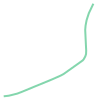

In [56]:
LineString(links['GEOMETRY'][0])

In [57]:
# convert to actual geometry object
links['GEOMETRY'] = links['GEOMETRY'].progress_apply(LineString)


100%|██████████| 134/134 [00:00<00:00, 45281.72it/s]

In [58]:
links_gpd = gpd.GeoDataFrame(links, geometry=links['GEOMETRY'])

In [59]:
links_gpd.head()

,LINK_ID,LINK_NAME,ENCODED_POLY_LINE,GEOMETRY,LINK_START,LINK_END,LINK_MIDDLE,START_ROAD,MIDDLE_ROAD,END_ROAD,ROAD,geometry
0,4616282,ROUTE 169 S - MLK WALKER STREET,_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,"LINESTRING (40.65632 -74.11972, 40.65504 -74.1...","(NJ 440, Bayonne, Hudson County, New Jersey, 0...","(Walker Street, Elm Park, Staten Island, Richm...","(NJ 440, Bayonne, Hudson County, New Jersey, 0...",NJ 440,NJ 440,Walker Street,DR M L KING JR EXPRESSWAY,"LINESTRING (40.65632 -74.11972, 40.65504 -74.1..."
1,4616299,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,"LINESTRING (40.76248 -73.83938999999999, 40.76...","(Northern Boulevard, East Elmhurst, Queens, Qu...","(Van Wyck Expressway, Kew Gardens, Queens, Que...","(Van Wyck Expressway, Queens, Queens County, N...",Northern Boulevard,Van Wyck Expressway,Van Wyck Expressway,VAN WYCK EXPRESSWAY,"LINESTRING (40.76248 -73.83938999999999, 40.76..."
2,4616300,VWE N MP8.64 (Exit 13 Northern Blvd) - Whitest...,iczwFlqsaMvBtEtBbEnChEvBfBxCdCnCjAjGtD`AZpBbAj...,"LINESTRING (40.77125 -73.83335, 40.77065 -73.8...","(Linden Place, Linden Hill, Queens, Queens Cou...","(Northern Boulevard, East Elmhurst, Queens, Qu...","(Van Wyck Expressway, Linden Hill, Queens, Que...",Linden Place,Van Wyck Expressway,Northern Boulevard,VAN WYCK EXPRESSWAY,"LINESTRING (40.77125 -73.83335, 40.77065 -73.8..."
3,4616305,BWB N Toll Plaza - HRP N Lafayatte Ave,isbxFxctaMkGCyIs@_NWgVb@iF`@,"LINESTRING (40.81477 -73.83629000000001, 40.81...","(Hutchinson River Expressway, Castle Hill, The...","(Hutchinson River Parkway, Schuylerville, The ...","(18, Hutchinson River Expressway, Schuylervill...",Hutchinson River Expressway,Hutchinson River Expressway,Hutchinson River Parkway,HUTCHINSON RIVER PARKWAY,"LINESTRING (40.81477 -73.83629000000001, 40.81..."
4,4616318,GOW N 7TH AVENUE - 9TH STREET,ue_wFbfwbMyBJyAX_Bp@oBhBiD|FmGxL_BzBuAbAoBv@mB...,"LINESTRING (40.63339 -74.01586, 40.634 -74.015...","(7th Avenue, Bay Ridge, Kings County, NYC, New...","(Gowanus Expressway, Carroll Gardens, Kings Co...","(Gowanus Expressway, Bay Ridge, Kings County, ...",7th Avenue,Gowanus Expressway,Gowanus Expressway,GOWANUS EXPRESSWAY,"LINESTRING (40.63339 -74.01586, 40.634 -74.015..."


In [60]:
link_roads = links.ROAD.unique()

sp_limits_gpd.loc[sp_limits_gpd.street == link_roads[0]]

,postvz_sg,postvz_sl,shape_leng,street,geometry
76921,YES,50,158.733369909,DR M L KING JR EXPRESSWAY,(LINESTRING (-74.15375068146861 40.61207615738...
76922,YES,50,77.3265446894,DR M L KING JR EXPRESSWAY,(LINESTRING (-74.1540373393307 40.611681876899...
76923,YES,50,620.364409505,DR M L KING JR EXPRESSWAY,(LINESTRING (-74.15329853906844 40.61435099023...
76924,YES,50,46.3481088999,DR M L KING JR EXPRESSWAY,(LINESTRING (-74.15360776567869 40.61264366055...
81241,YES,50,279.13164924,DR M L KING JR EXPRESSWAY,(LINESTRING (-74.15409312966626 40.61147393358...
82982,YES,50,209.153083535,DR M L KING JR EXPRESSWAY,(LINESTRING (-74.15420660569558 40.61037968325...
82983,YES,50,230.32342881,DR M L KING JR EXPRESSWAY,(LINESTRING (-74.15439302951113 40.61045597652...
82984,YES,50,42.9959637555,DR M L KING JR EXPRESSWAY,(LINESTRING (-74.15379616126164 40.61257780466...
83054,YES,50,45.9132099563,DR M L KING JR EXPRESSWAY,(LINESTRING (-74.15282510081086 40.61538564087...
83055,YES,50,43.9233777482,DR M L KING JR EXPRESSWAY,(LINESTRING (-74.1530319536144 40.615392867035...


In [61]:
sp_limits_gpd['center_point'] = sp_limits_gpd['geometry'].apply(lambda x: x.centroid.wkt)

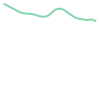

In [62]:
links_gpd['geometry'][1]

In [63]:
import shapely.geometry

links_gpd['geometry'][1].distance(sp_limits_gpd['geometry'][1])

162.1440273230386

In [64]:
sp_limits_gpd = sp_limits_gpd.reset_index()

In [65]:
sp_limits_gpd = sp_limits_gpd.rename(columns={'index':'road_id'})

In [66]:
links_gpd.columns

Index(['LINK_ID', 'LINK_NAME', 'ENCODED_POLY_LINE', 'GEOMETRY', 'LINK_START',
       'LINK_END', 'LINK_MIDDLE', 'START_ROAD', 'MIDDLE_ROAD', 'END_ROAD',
       'ROAD', 'geometry'],
      dtype='object')

In [67]:
sp_limits_gpd.columns

Index(['road_id', 'postvz_sg', 'postvz_sl', 'shape_leng', 'street', 'geometry',
       'center_point'],
      dtype='object')

In [68]:
#speed_limits = pd.DataFrame(columns=['id', 'limit'])
speed_id = []
final_distance = []
final_speed_limit = []
link_id = []

for line in links_gpd.index:
    # add the link id
    link_id.append(links_gpd['LINK_ID'][line])
    
    # add all of the indexes for the road into a list
    index = sp_limits_gpd.loc[sp_limits_gpd.street == links_gpd['ROAD'][line]].index
    
    distance = []
    speed_limit = []
    
    # loop over each of the roads in the speed limits dataset
    for i in sp_limits_gpd.loc[sp_limits_gpd.street == links_gpd['ROAD'][line]].index:
        # find the distance between the link line and all of the matching road lines
        row = links_gpd['geometry'][line].distance(sp_limits_gpd['geometry'][i])
        # add all of the speed limits for this road
        speed_limit.append(sp_limits_gpd['postvz_sl'][i])
        distance.append(row)

    speed_limits_temp = pd.DataFrame()
    speed_limits_temp['id'] = index
    speed_limits_temp['distance'] = distance
    speed_limits_temp['speed_limit'] = speed_limit
    minimum = speed_limits_temp.loc[speed_limits_temp.distance == speed_limits_temp.distance.min()]
    speed_id.append(minimum['id'].values)
    final_speed_limit.append(minimum['speed_limit'].values)
    final_distance.append(minimum['distance'].values)
    

speed_limits = pd.DataFrame()
speed_limits['link_id'] = link_id
speed_limits['speed_id'] = speed_id
speed_limits['speed_limit'] = final_speed_limit

speed_limits.tail(10)

,link_id,speed_id,speed_limit
124,4456481,[91798],[40]
125,4362249,[112923],[50]
126,4362342,[112923],[50]
127,4456450,[96067],[40]
128,4456476,[91798],[40]
129,4763651,"[82174, 92493]","[35, 35]"
130,4763650,"[82174, 92493]","[35, 35]"
131,4456452,[91798],[40]
132,4362250,[111292],[50]
133,4362251,[112923],[50]


In [69]:
speed_limits['speed_id'][130][0]

82174

In [70]:
for i in speed_limits.index:
    speed_limits['speed_id'][i] = speed_limits['speed_id'][i][0]
    speed_limits['speed_limit'][i] = speed_limits['speed_limit'][i][0]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [71]:
speed_limits.tail()

,link_id,speed_id,speed_limit
129,4763651,82174,35
130,4763650,82174,35
131,4456452,91798,40
132,4362250,111292,50
133,4362251,112923,50


In [72]:
speed_limits = speed_limits.rename(columns={'link_id':'LINK_ID'})
links_gpd = links_gpd.merge(speed_limits, on='LINK_ID')

links_gpd

,LINK_ID,LINK_NAME,ENCODED_POLY_LINE,GEOMETRY,LINK_START,LINK_END,LINK_MIDDLE,START_ROAD,MIDDLE_ROAD,END_ROAD,ROAD,geometry,speed_id,speed_limit
0,4616282,ROUTE 169 S - MLK WALKER STREET,_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,"LINESTRING (40.65632 -74.11972, 40.65504 -74.1...","(NJ 440, Bayonne, Hudson County, New Jersey, 0...","(Walker Street, Elm Park, Staten Island, Richm...","(NJ 440, Bayonne, Hudson County, New Jersey, 0...",NJ 440,NJ 440,Walker Street,DR M L KING JR EXPRESSWAY,"LINESTRING (40.65632 -74.11972, 40.65504 -74.1...",91236,50
1,4616299,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,"LINESTRING (40.76248 -73.83938999999999, 40.76...","(Northern Boulevard, East Elmhurst, Queens, Qu...","(Van Wyck Expressway, Kew Gardens, Queens, Que...","(Van Wyck Expressway, Queens, Queens County, N...",Northern Boulevard,Van Wyck Expressway,Van Wyck Expressway,VAN WYCK EXPRESSWAY,"LINESTRING (40.76248 -73.83938999999999, 40.76...",77399,50
2,4616300,VWE N MP8.64 (Exit 13 Northern Blvd) - Whitest...,iczwFlqsaMvBtEtBbEnChEvBfBxCdCnCjAjGtD`AZpBbAj...,"LINESTRING (40.77125 -73.83335, 40.77065 -73.8...","(Linden Place, Linden Hill, Queens, Queens Cou...","(Northern Boulevard, East Elmhurst, Queens, Qu...","(Van Wyck Expressway, Linden Hill, Queens, Que...",Linden Place,Van Wyck Expressway,Northern Boulevard,VAN WYCK EXPRESSWAY,"LINESTRING (40.77125 -73.83335, 40.77065 -73.8...",77399,50
3,4616305,BWB N Toll Plaza - HRP N Lafayatte Ave,isbxFxctaMkGCyIs@_NWgVb@iF`@,"LINESTRING (40.81477 -73.83629000000001, 40.81...","(Hutchinson River Expressway, Castle Hill, The...","(Hutchinson River Parkway, Schuylerville, The ...","(18, Hutchinson River Expressway, Schuylervill...",Hutchinson River Expressway,Hutchinson River Expressway,Hutchinson River Parkway,HUTCHINSON RIVER PARKWAY,"LINESTRING (40.81477 -73.83629000000001, 40.81...",124226,50
4,4616318,GOW N 7TH AVENUE - 9TH STREET,ue_wFbfwbMyBJyAX_Bp@oBhBiD|FmGxL_BzBuAbAoBv@mB...,"LINESTRING (40.63339 -74.01586, 40.634 -74.015...","(7th Avenue, Bay Ridge, Kings County, NYC, New...","(Gowanus Expressway, Carroll Gardens, Kings Co...","(Gowanus Expressway, Bay Ridge, Kings County, ...",7th Avenue,Gowanus Expressway,Gowanus Expressway,GOWANUS EXPRESSWAY,"LINESTRING (40.63339 -74.01586, 40.634 -74.015...",76630,50
5,4616319,GOW S 9TH STREET - 7TH AVENUE,ud_wF|gwbMgCCwATcBr@_BvAqDhGmGtL{AxB}AlAsBt@uB...,"LINESTRING (40.63323 -74.01615, 40.63391 -74.0...","(Gowanus Expressway, Bay Ridge, Kings County, ...","(310, Hamilton Avenue, Carroll Gardens, Kings ...","(6100, Gowanus Expressway, Bay Ridge, Kings Co...",Gowanus Expressway,Gowanus Expressway,Hamilton Avenue,GOWANUS EXPRESSWAY,"LINESTRING (40.63323 -74.01615, 40.63391 -74.0...",76630,50
6,4616320,CIP N TNB - Whitestone Expwy S Exit 14 (Linden...,_u}wFhkjaMr@dI~A~HtA|EbEnKxBdHv@~Cv@jGRhCJ~G[p...,"LINESTRING (40.78944 -73.78628999999999, 40.78...","(Cross Island Parkway, Beechhurst, Queens, Que...","(Linden Place, Linden Hill, Queens, Queens Cou...","(36N;36S, Cross Island Parkway Westbound, Beec...",Cross Island Parkway,Cross Island Parkway Westbound,Linden Place,CROSS ISLAND PARKWAY,"LINESTRING (40.78944 -73.78628999999999, 40.78...",134844,50
7,4616324,12th ave @ 45th - 11 ave ganservoort st,mtxwF|}sbMl@^~GpK|LrIbLlH??lK~G|FtD`C~@}@WdWnG...,"LINESTRING (40.76375 -73.99919, 40.76352 -73.9...","(independent, 12th Avenue, Hell's Kitchen, Man...","(West Street, Meatpacking District, Manhattan,...","(12th Avenue, Hudson Yards, Manhattan, Manhatt...",12th Avenue,12th Avenue,West Street,12 AVENUE,"LINESTRING (40.76375 -73.99919, 40.76352 -73.9...",68438,25
8,4616325,11th ave s ganservoort - west st @ spring st,y{swFvavbMjANlGSvQn@fa@fBhQdA,"LINESTRING (40.73933 -74.01004, 40.73895 -74.0...","(198, Gansevoort Street, Meatpacking District,...","(West Street, Hudson Square, Manhattan, Manhat...","(West Street, Meatpacking District, Manhattan,...",Gansevoort Street,West Street,West Street,WE

___

### Load LION Data

In [73]:
lion = gpd.read_file('nyu_2451_34565/nyu_2451_34565.shp')

In [74]:
lion.head()

,Street,SAFStreetN,FeatureTyp,SegmentTyp,IncExFlag,RB_Layer,NonPed,TrafDir,TrafSrc,SpecAddr,...,LHi_Hyphen,RLo_Hyphen,RHi_Hyphen,FromLeft,ToLeft,FromRight,ToRight,Join_ID,SHAPE_Leng,geometry
0,EAST 168 STREET,None,0,U,None,B,None,T,DOT,None,...,699,596,716,599,699,596,716,2251001000000,437.282051,LINESTRING (1010964.446978778 241812.261403456...
1,WEST 192 STREET,None,0,U,None,B,None,A,DOT,None,...,98,63,99,58,98,63,99,2798401000000,279.360514,LINESTRING (1011576.686607853 255023.583030954...
2,UNION AVENUE,None,0,U,None,B,None,W,DOT,None,...,1079,1016,1084,1017,1079,1016,1084,2728001000000,618.327133,LINESTRING (1011600.676209003 239639.742800265...
3,UNION AVENUE,BEHAGEN PLAYGROUND,0,U,None,B,None,W,DOT,N,...,None,None,None,0,0,0,0,21279501000000N,618.327133,LINESTRING (1011600.676209003 239639.742800265...
4,DELAFIELD AVENUE,None,6,U,None,B,None,T,DOT,None,...,4645,4600,4664,4601,4645,4600,4664,2187601000000,670.281037,LINESTRING (1009974.212831751 264857.139198020...


In [75]:
lion.shape

(218349, 114)

In [76]:
lion.Street.value_counts()

2000 CB BOUNDARY              5359
ALLEY                         4076
DISTRICT BOUNDARY             3009
2010 CB BOUNDARY              2445
BELT PARKWAY                  1594
LONG ISLAND EXPRESSWAY        1202
BROADWAY                      1171
QUEENS BOULEVARD              1108
LINDEN BOULEVARD              1041
UNNAMED STREET                1012
PIER                           997
CT BOUNDARY                    993
GRAND CENTRAL PARKWAY          965
F D R DRIVE                    909
ATLANTIC AVENUE                829
BROOKLYN QUEENS EXPRESSWAY     800
CONNECTOR                      798
UNION TURNPIKE                 769
3 AVENUE                       766
CROSS BRONX EXPRESSWAY         719
VAN WYCK EXPRESSWAY            701
FRANCIS LEWIS BOULEVARD        688
PEDESTRIAN PATH                683
CROSS ISLAND PARKWAY           658
PARK AVENUE                    653
BRUCKNER BOULEVARD             589
GOWANUS EXPRESSWAY             568
HYLAN BOULEVARD                550
DRIVEWAY            

In [77]:
lion.columns

Index(['Street', 'SAFStreetN', 'FeatureTyp', 'SegmentTyp', 'IncExFlag',
       'RB_Layer', 'NonPed', 'TrafDir', 'TrafSrc', 'SpecAddr',
       ...
       'LHi_Hyphen', 'RLo_Hyphen', 'RHi_Hyphen', 'FromLeft', 'ToLeft',
       'FromRight', 'ToRight', 'Join_ID', 'SHAPE_Leng', 'geometry'],
      dtype='object', length=114)

In [78]:
lion_links = lion.loc[lion.Street==links_gpd.ROAD.unique()[0]]
for i in range(1, len(links_gpd.ROAD.unique())):
    next_row = lion.loc[lion.Street==links_gpd.ROAD.unique()[i]]
    lion_links = lion_links.append(next_row)

lion_links

,Street,SAFStreetN,FeatureTyp,SegmentTyp,IncExFlag,RB_Layer,NonPed,TrafDir,TrafSrc,SpecAddr,...,LHi_Hyphen,RLo_Hyphen,RHi_Hyphen,FromLeft,ToLeft,FromRight,ToRight,Join_ID,SHAPE_Leng,geometry
190829,DR M L KING JR EXPRESSWAY,None,0,G,None,G,V,T,DCP,None,...,None,None,None,0,0,0,0,5214701000000,330.371048,"LINESTRING (943820.3151896 168375.2288153768, ..."
190830,DR M L KING JR EXPRESSWAY,None,0,G,None,G,V,T,DCP,None,...,None,None,None,0,0,0,0,5214701000000,653.721521,LINESTRING (943786.3290879875 169178.993553564...
190925,DR M L KING JR EXPRESSWAY,None,0,G,None,G,V,T,DCP,None,...,None,None,None,0,0,0,0,5214701000000,338.335545,LINESTRING (941490.2247789353 162086.931216701...
190937,DR M L KING JR EXPRESSWAY,None,0,G,None,G,V,T,DCP,None,...,None,None,None,0,0,0,0,5214701000000,53.579071,LINESTRING (941561.9075823277 162427.462032884...
191852,DR M L KING JR EXPRESSWAY,None,0,T,None,R,V,A,DCP,None,...,None,None,None,0,0,0,0,5214701020000,70.263875,LINESTRING (941414.5256753266 161483.878188058...
191973,DR M L KING JR EXPRESSWAY,None,0,R,None,R,V,A,DCP,None,...,None,None,None,0,0,0,0,5214701020000,98.027399,LINESTRING (943906.4337936938 170021.121193558...
191977,DR M L KING JR EXPRESSWAY,None,0,R,None,R,V,W,DCP,None,...,None,None,None,0,0,0,0,5214701030000,373.619477,LINESTRING (941998.4258030653 164299.072421774...
192261,DR M L KING JR EXPRESSWAY,None,0,R,None,R,V,A,DCP,None,...,None,None,None,0,0,0,0,5214701020000,302.065441,LINESTRING (943886.7059927583 169925.107588991...
192273,DR M L KING JR EXPRESSWAY,None,0,R,None,R,V,A,DCP,None,...,None,None,None,0,0,0,0,5214701020000,48.250202,LINESTRING (941570.7430827469 162357.091429531...
192363,DR M L KING JR EXPRESSWAY,None,0,R,None,R,V,W,DCP,None,...,None,None,None,0,0,0,0,5214701030000,279.131571,LINESTRING (941466.2156777829 162090.461416870...


In [79]:
lion_links.columns[60:120]

Index(['LSchlDist', 'RSchlDist', 'SplitSchl', 'LSubSect', 'RSubSect',
       'SanDistInd', 'MapFrom', 'MapTo', 'BoroBndry', 'MH_RI_Flag', 'XFrom',
       'YFrom', 'XTo', 'YTo', 'ArcCenterX', 'ArcCenterY', 'CurveFlag',
       'Radius', 'NodeIDFrom', 'NodeIDTo', 'NodeLevelF', 'NodeLevelT',
       'ConParity', 'Twisted', 'RW_TYPE', 'PhysicalID', 'GenericID', 'NYPDID',
       'FDNYID', 'LBlockFace', 'RBlockFace', 'LegacyID', 'Status',
       'StreetWidt', 'StreetWi_1', 'BikeLane', 'Snow_Prior', 'Number_Tra',
       'Number_Par', 'Number_Tot', 'Carto_Disp', 'FCC', 'ROW_Type',
       'LLo_Hyphen', 'LHi_Hyphen', 'RLo_Hyphen', 'RHi_Hyphen', 'FromLeft',
       'ToLeft', 'FromRight', 'ToRight', 'Join_ID', 'SHAPE_Leng', 'geometry'],
      dtype='object')

In [80]:
lion_links['Number_Tra'].value_counts()

3     5307
2     1681
4      982
1      415
5       96
6        8
10       4
12       4
8        4
Name: Number_Tra, dtype: int64

In [81]:
lion_sm = lion_links[['Street', 'FeatureTyp', 'SegmentTyp','RB_Layer', 'NonPed', 'TrafDir', 
                      'SeqNum', 'StreetCode', 'StreetWidt', 'BikeLane', 'Snow_Prior', 'Number_Tra',
                      'Number_Tot', 'Carto_Disp', 'ROW_Type', 'Join_ID', 'SHAPE_Leng', 'geometry']]
lion_sm = lion_sm.reset_index()

lion_sm = lion_sm.rename(columns={'index':'lion_id'})

# dropping the rows that have None for their lane number
lion_sm = lion_sm.dropna(subset=['Number_Tra'])

lion_sm

,lion_id,Street,FeatureTyp,SegmentTyp,RB_Layer,NonPed,TrafDir,SeqNum,StreetCode,StreetWidt,BikeLane,Snow_Prior,Number_Tra,Number_Tot,Carto_Disp,ROW_Type,Join_ID,SHAPE_Leng,geometry
4,191852,DR M L KING JR EXPRESSWAY,0,T,R,V,A,00530,570359,16.0,None,P,2,2,10,None,5214701020000,70.263875,LINESTRING (941414.5256753266 161483.878188058...
6,191977,DR M L KING JR EXPRESSWAY,0,R,R,V,W,00670,570359,22.0,None,P,2,2,10,None,5214701030000,373.619477,LINESTRING (941998.4258030653 164299.072421774...
8,192273,DR M L KING JR EXPRESSWAY,0,R,R,V,A,00480,570359,40.0,None,P,3,3,10,None,5214701020000,48.250202,LINESTRING (941570.7430827469 162357.091429531...
9,192363,DR M L KING JR EXPRESSWAY,0,R,R,V,W,00760,570359,15.0,None,P,1,1,10,None,5214701030000,279.131571,LINESTRING (941466.2156777829 162090.461416870...
10,192388,DR M L KING JR EXPRESSWAY,0,R,R,V,W,00620,570359,28.0,None,P,3,3,10,None,5214701030000,188.476188,LINESTRING (943818.2449894994 168045.222999706...
12,194170,DR M L KING JR EXPRESSWAY,0,R,R,V,W,00550,570359,30.0,None,P,2,2,10,None,5214701030000,246.599446,LINESTRING (943784.0191878825 169630.019574984...
13,194172,DR M L KING JR EXPRESSWAY,0,T,R,V,W,00790,570359,26.0,None,P,1,1,10,None,5214701030000,79.655348,LINESTRING (941336.2092716098 161494.074788540...
14,194439,DR M L KING JR EXPRESSWAY,0,R,R,V,A,00510,570359,25.0,None,P,2,2,10,None,5214701020000,106.326019,LINESTRING (941455.2806772739 161796.029602885...
15,194440,DR M L KING JR EXPRESSWAY,0,R,R,V,A,00450,570359,30.0,None,P,2,2,10,None,5214701020000,623.599461,"LINESTRING (941731.0673903674 163126.42396608,..."
16,194441,DR M L KING JR EXPRESSWAY,0,R,R,V,A,00470,570359,40.0,None,P,3,3,10,None,5214701020000,53.093603,LINESTRING (941580.2933832109 162409.319032013...


In [82]:
final_lion_id = []
final_distance = []
link_id = []

for line in links_gpd.index:
    # add the link id
    link_id.append(links_gpd['LINK_ID'][line])
    
    # add all of the indexes for the road into a list
    index = lion_sm['lion_id'].loc[lion_sm.Street == links_gpd['ROAD'][line]]
    
    distance = []
    
    # loop over each of the roads in the speed limits dataset
    for i in lion_sm.loc[lion_sm.Street == links_gpd['ROAD'][line]].index:
        # find the distance between the link line and all of the matching road lines
        row = links_gpd['geometry'][line].distance(lion_sm['geometry'][i])
        # add all of the speed limits for this road
        distance.append(row)

    lions_temp = pd.DataFrame()
    lions_temp['lion_id'] = index
    lions_temp['distance'] = distance
    minimum = lions_temp.loc[lions_temp.distance == lions_temp.distance.min()]
    final_lion_id.append(minimum['lion_id'].values)
    final_distance.append(minimum['distance'].values)
    

lion_links = pd.DataFrame()
lion_links['link_id'] = link_id
lion_links['lion_id'] = final_lion_id

lion_links.tail(10)

,link_id,lion_id
126,4456496,[29565]
127,4456481,[94835]
128,4362249,[145462]
129,4362342,[145462]
130,4456450,[93132]
131,4456476,[94835]
132,4763651,"[211064, 211065]"
133,4763650,"[211064, 211065]"
134,4456452,[94835]
135,4362250,[133958]


In [83]:
lion_links.tail(60)

,link_id,lion_id
76,4616219,"[211064, 211065]"
77,4616218,"[211064, 211065]"
78,4616215,[198259]
79,4616214,[198259]
80,4616213,[198259]
81,4616212,[198259]
82,4616211,[192638]
83,4616209,[192638]
84,4616208,[193656]
85,4616206,[192638]


In [84]:
for i in lion_links.index:
    lion_links['lion_id'][i] = lion_links['lion_id'][i][0]
    
lion_links['lion_id'].value_counts()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


192638    10
211064    10
167972     9
140154     8
145462     7
198259     7
93132      7
46259      6
68907      6
94835      6
7769       6
29565      5
194172     5
99333      5
87436      4
199679     4
139913     3
27262      3
52986      3
99222      3
142208     3
92922      2
98506      2
192360     2
96873      2
28809      2
200255     2
104862     1
193656     1
133958     1
197039     1
Name: lion_id, dtype: int64

In [85]:
lion_links.shape

(136, 2)

In [86]:
links_gpd.shape

(136, 14)

In [87]:
lion_links = lion_links.rename(columns={'link_id':'LINK_ID'})
links_lion_gpd = links_gpd.merge(lion_links, on='LINK_ID')

links_lion_gpd['LINK_ID'].value_counts()

4362251    16
4456510     1
4620332     1
4456498     1
4616241     1
4456496     1
4616239     1
4616193     1
4620331     1
4456501     1
4620330     1
4616232     1
4616229     1
4616228     1
4329507     1
4616226     1
4456500     1
4616246     1
4763648     1
4616247     1
4456505     1
4616250     1
4456481     1
4616252     1
4456511     1
4616255     1
4362247     1
4616259     1
4616260     1
4616261     1
           ..
4616276     1
4456450     1
4616281     1
4616282     1
4616202     1
4456483     1
4616203     1
4362342     1
4456452     1
4763650     1
4616297     1
4616298     1
4616299     1
4616300     1
4362252     1
4616305     1
4616309     1
4616310     1
4456494     1
4616312     1
4763655     1
4616318     1
4616319     1
4616320     1
4616323     1
4616324     1
4616325     1
4616219     1
4616328     1
4329472     1
Name: LINK_ID, Length: 133, dtype: int64

In [88]:
links_merge = links_lion_gpd.merge(lion_sm, on='lion_id')
links_merge.head()

,LINK_ID,LINK_NAME,ENCODED_POLY_LINE,GEOMETRY,LINK_START,LINK_END,LINK_MIDDLE,START_ROAD,MIDDLE_ROAD,END_ROAD,...,StreetWidt,BikeLane,Snow_Prior,Number_Tra,Number_Tot,Carto_Disp,ROW_Type,Join_ID,SHAPE_Leng,geometry_y
0,4616282,ROUTE 169 S - MLK WALKER STREET,_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,"LINESTRING (40.65632 -74.11972, 40.65504 -74.1...","(NJ 440, Bayonne, Hudson County, New Jersey, 0...","(Walker Street, Elm Park, Staten Island, Richm...","(NJ 440, Bayonne, Hudson County, New Jersey, 0...",NJ 440,NJ 440,Walker Street,...,26.0,None,P,1,1,10,None,5214701030000,79.655348,LINESTRING (941336.2092716098 161494.074788540...
1,4329499,MLK N WALKER STREET - NJ ROUTE 169,cv~vFpqpcMqI_@_JoA{Dk@mY}Ig^yKwL{DyCmA{]_UgDyC...,"LINESTRING (40.6309 -74.14569, 40.63259 -74.14...","(Walker Street, Elm Park, Staten Island, Richm...","(NJ 440, Bayonne, Hudson County, New Jersey, 0...","(NJ 440, Bayonne, Hudson County, New Jersey, 1...",Walker Street,NJ 440,NJ 440,...,26.0,None,P,1,1,10,None,5214701030000,79.655348,LINESTRING (941336.2092716098 161494.074788540...
2,4616196,MLK S - SIE E WALKER STREET - WOOLEY AVENUE,gv~vF~rpcMhF@bE[bDWbD@vCb@|D~@dCf@`Cv@jCjA~CzA...,"LINESTRING (40.63092 -74.14592, 40.62975 -74.1...","(Walker Street, Elm Park, Staten Island, Richm...","(Staten Island Expressway, Willowbrook, Staten...","(Dr. Martin Luther King Jr. Expressway, Granit...",Walker Street,Dr. Martin Luther King Jr. Expressway,Staten Island Expressway,...,26.0,None,P,1,1,10,None,5214701030000,79.655348,LINESTRING (941336.2092716098 161494.074788540...
3,4616210,MLK S - SIE W WALKER STREET - RICHMOND AVENUE,gv~vF~rpcMhF@bE[bDWbD@vCb@|D~@dCf@`Cv@jCjA~CzA...,"LINESTRING (40.63092 -74.14592, 40.62975 -74.1...","(Walker Street, Elm Park, Staten Island, Richm...","(Staten Island Expressway, Bulls Head, Staten ...","(Dr. Martin Luther King Jr. Expressway, Granit...",Walker Street,Dr. Martin Luther King Jr. Expressway,Staten Island Expressway,...,26.0,None,P,1,1,10,None,5214701030000,79.655348,LINESTRING (941336.2092716098 161494.074788540...
4,4616216,SIE E-MLK N RICHMOND AVENUE - WALKER STREET,av~vFpqpcMxE?`EYzCUfD@|CZtDdAnCd@`Cz@rCdAzCzAv...,"LINESTRING (40.63089 -74.14569, 40.6298 -74.14...","(1, Dr. Martin Luther King Jr. Expressway, Elm...","(9, Staten Island Expressway, Bulls Head, Stat...","(12, Dr. Martin Luther King Jr. Expressway, Gr...",Dr. Martin Luther King Jr. Expressway,Dr. Martin Luther King Jr. Expressway,Staten Island Expressway,...,26.0,None,P,1,1,10,None,5214701030000,79.655348,LINESTRING (941336.2092716098 161494.074788540...


In [89]:
links_merge.columns

Index(['LINK_ID', 'LINK_NAME', 'ENCODED_POLY_LINE', 'GEOMETRY', 'LINK_START',
       'LINK_END', 'LINK_MIDDLE', 'START_ROAD', 'MIDDLE_ROAD', 'END_ROAD',
       'ROAD', 'geometry_x', 'speed_id', 'speed_limit', 'lion_id', 'Street',
       'FeatureTyp', 'SegmentTyp', 'RB_Layer', 'NonPed', 'TrafDir', 'SeqNum',
       'StreetCode', 'StreetWidt', 'BikeLane', 'Snow_Prior', 'Number_Tra',
       'Number_Tot', 'Carto_Disp', 'ROW_Type', 'Join_ID', 'SHAPE_Leng',
       'geometry_y'],
      dtype='object')

In [90]:
links_merge.loc[links_merge['LINK_ID']==4362251]

,LINK_ID,LINK_NAME,ENCODED_POLY_LINE,GEOMETRY,LINK_START,LINK_END,LINK_MIDDLE,START_ROAD,MIDDLE_ROAD,END_ROAD,...,StreetWidt,BikeLane,Snow_Prior,Number_Tra,Number_Tot,Carto_Disp,ROW_Type,Join_ID,SHAPE_Leng,geometry_y
94,4362251,LIE WB LITTLE NECK PKWY - NB CVE,}uvwFlebaMkMcUcIkNoH}N}AeEaAaEqC_KqAuDaCsE_EgH...,"LINESTRING (40.75375 -73.74439, 40.75605 -73.7...","(30W, Cross Island Parkway, Bellerose Terrace,...","(Little Neck Parkway, Little Neck, Queens Coun...","(Long Island Expressway, Little Neck, Queens C...",Cross Island Parkway,Long Island Expressway,Little Neck Parkway,...,32.0,None,P,3,3,10,None,4276606111618,78.075676,LINESTRING (998229.8993739188 209457.514266684...
95,4362251,LIE WB LITTLE NECK PKWY - NB CVE,}uvwFlebaMkMcUcIkNoH}N}AeEaAaEqC_KqAuDaCsE_EgH...,"LINESTRING (40.75375 -73.74439, 40.75605 -73.7...","(30W, Cross Island Parkway, Bellerose Terrace,...","(Little Neck Parkway, Little Neck, Queens Coun...","(Long Island Expressway, Little Neck, Queens C...",Cross Island Parkway,Long Island Expressway,Little Neck Parkway,...,32.0,None,P,3,3,10,None,4276606111618,78.075676,LINESTRING (998229.8993739188 209457.514266684...
96,4362251,LIE WB LITTLE NECK PKWY - NB CVE,}uvwFlebaMkMcUcIkNoH}N}AeEaAaEqC_KqAuDaCsE_EgH...,"LINESTRING (40.75375 -73.74439, 40.75605 -73.7...","(30W, Cross Island Parkway, Bellerose Terrace,...","(Little Neck Parkway, Little Neck, Queens Coun...","(Long Island Expressway, Little Neck, Queens C...",Cross Island Parkway,Long Island Expressway,Little Neck Parkway,...,32.0,None,P,3,3,10,None,4276606111618,78.075676,LINESTRING (998229.8993739188 209457.514266684...
97,4362251,LIE WB LITTLE NECK PKWY - NB CVE,}uvwFlebaMkMcUcIkNoH}N}AeEaAaEqC_KqAuDaCsE_EgH...,"LINESTRING (40.75375 -73.74439, 40.75605 -73.7...","(30W, Cross Island Parkway, Bellerose Terrace,...","(Little Neck Parkway, Little Neck, Queens Coun...","(Long Island Expressway, Little Neck, Queens C...",Cross Island Parkway,Long Island Expressway,Little Neck Parkway,...,32.0,None,P,3,3,10,None,4276606111618,78.075676,LINESTRING (998229.8993739188 209457.514266684...
98,4362251,LIE WB LITTLE NECK PKWY - NB CVE,}uvwFlebaMkMcUcIkNoH}N}AeEaAaEqC_KqAuDaCsE_EgH...,"LINESTRING (40.75375 -73.74439, 40.75605 -73.7...","(30W, Cross Island Parkway, Bellerose Terrace,...","(Little Neck Parkway, Little Neck, Queens Coun...","(Long Island Expressway, Little Neck, Queens C...",Cross Island Parkway,Long Island Expressway,Little Neck Parkway,...,32.0,None,P,3,3,10,None,4276606111618,78.075676,LINESTRING (998229.8993739188 209457.514266684...
99,4362251,LIE WB LITTLE NECK PKWY - NB CVE,}uvwFlebaMkMcUcIkNoH}N}AeEaAaEqC_KqAuDaCsE_EgH...,"LINESTRING (40.75375 -73.74439, 40.75605 -73.7...","(30W, Cross Island Parkway, Bellerose Terrace,...","(Little Neck Parkway, Little Neck, Queens Coun...","(Long Island Expressway, Little Neck, Queens C...",Cross Island Parkway,Long Island Expressway,Little Neck Parkway,...,32.0,None,P,3,3,10,None,4276606111618,78.075676,LINESTRING (998229.8993739188 209457.514266684...
100,4362251,LIE WB LITTLE NECK PKWY - NB CVE,}uvwFlebaMkMcUcIkNoH}N}AeEaAaEqC_KqAuDaCsE_EgH...,"LINESTRING (40.75375 -73.74439, 40.75605 -73.7...","(30W, Cross Island Parkway, Bellerose Terrace,...","(Little Neck Parkway, Little Neck, Queens Coun...","(Long Island Expressway, Little Neck, Queens C...",Cross Island Parkway,Long Island Expressway,Little Neck Parkway,...,32.0,None,P,3,3,10,None,4276606111618,78.075676,LINESTRING (998229.8993739188 209457.514266684...
101,4362251,LIE WB LITTLE NECK PKWY - NB CVE,}uvwFlebaMkMcUcIkNoH}N}AeEaAaEqC_KqAuDaCsE_EgH...,"LINESTRING (40.75375 -73.74439, 40.75605 -73.7...","(30W, Cross Island Parkway, Bellerose Terrace,...","(Little Neck Parkway, Little Neck, Queens Coun...","(Long Island Expressway, Little Neck, Queens C...",Cross Island Parkway,Long Island Expressway,Little Neck Parkway,...,32.0,None,P,3,3,10,None,4276606111618,78.075676,LINESTRING (998229.8993739188 209457.514266684...
102,4362251,LIE WB LITTLE NECK PKWY,}

In [91]:
links_merge = links_merge.drop_duplicates(subset='LINK_ID')

In [92]:
links_merge.loc[links_merge['geometry_x'] == links_merge['geometry_x'].value_counts().index.tolist()[0]]

,LINK_ID,LINK_NAME,ENCODED_POLY_LINE,GEOMETRY,LINK_START,LINK_END,LINK_MIDDLE,START_ROAD,MIDDLE_ROAD,END_ROAD,...,StreetWidt,BikeLane,Snow_Prior,Number_Tra,Number_Tot,Carto_Disp,ROW_Type,Join_ID,SHAPE_Leng,geometry_y
55,4616209,SIE W WOOLEY AVENUE - RICHMOND AVENUE,at{vFvzrcMbQsVlP{UjCkFbBsFxAkJ\{HKiS,"LINESTRING (40.61521 -74.1574, 40.61231 -74.15...","(Staten Island Expressway, Bulls Head, Staten ...","(Staten Island Expressway, Castleton Corners, ...","(Staten Island Expressway, Castleton Corners, ...",Staten Island Expressway,Staten Island Expressway,Staten Island Expressway,...,60.0,None,P,4,4,10,None,5154601060000,553.375098,"LINESTRING (934168.00863114 167655.5813812017,..."


In [93]:
links_merge.shape

(133, 33)

In [94]:
links_merge.loc[links_merge['BikeLane']=='1']

,LINK_ID,LINK_NAME,ENCODED_POLY_LINE,GEOMETRY,LINK_START,LINK_END,LINK_MIDDLE,START_ROAD,MIDDLE_ROAD,END_ROAD,...,StreetWidt,BikeLane,Snow_Prior,Number_Tra,Number_Tot,Carto_Disp,ROW_Type,Join_ID,SHAPE_Leng,geometry_y
142,4456479,BE S TBB EXIT RAMP - MANHATTAN LIFT SPAN,yi_xFfndbMb@^Xb@ThAEbB_@nByAbEm@fAkAbDiAlDo@nB...,"LINESTRING (40.79789 -73.91988000000001, 40.79...","(48, Bronx Shore Road, Manhattan Community Boa...","(2445, 1st Avenue, East Harlem, Manhattan, Man...","(30, Bronx Shore Road, Manhattan Community Boa...",Bronx Shore Road,Bronx Shore Road,1st Avenue,...,20.0,1,V,1,1,None,None,1076401000000,264.673436,LINESTRING (1004638.826778322 230530.636367604...


___

In [95]:
links_merge.columns

Index(['LINK_ID', 'LINK_NAME', 'ENCODED_POLY_LINE', 'GEOMETRY', 'LINK_START',
       'LINK_END', 'LINK_MIDDLE', 'START_ROAD', 'MIDDLE_ROAD', 'END_ROAD',
       'ROAD', 'geometry_x', 'speed_id', 'speed_limit', 'lion_id', 'Street',
       'FeatureTyp', 'SegmentTyp', 'RB_Layer', 'NonPed', 'TrafDir', 'SeqNum',
       'StreetCode', 'StreetWidt', 'BikeLane', 'Snow_Prior', 'Number_Tra',
       'Number_Tot', 'Carto_Disp', 'ROW_Type', 'Join_ID', 'SHAPE_Leng',
       'geometry_y'],
      dtype='object')

In [96]:
links_merge['SegmentTyp'].value_counts()

R    92
U    16
E    12
T    11
S     2
Name: SegmentTyp, dtype: int64

In [97]:
links_merge = links_merge.drop(columns=['Carto_Disp','LINK_NAME','ENCODED_POLY_LINE','GEOMETRY','START_ROAD', 'MIDDLE_ROAD', 
                                        'END_ROAD','ROAD','ROW_Type'])

In [98]:
links_merge['BikeLane'] = np.where(links_merge['BikeLane']==None,1,0)

In [99]:
links_merge.shape

(133, 24)

In [100]:
links_merge['Number_Tot'].value_counts()

2    52
3    46
4    19
1    11
6     5
Name: Number_Tot, dtype: int64

In [101]:
links_merge.head()

,LINK_ID,LINK_START,LINK_END,LINK_MIDDLE,geometry_x,speed_id,speed_limit,lion_id,Street,FeatureTyp,...,SeqNum,StreetCode,StreetWidt,BikeLane,Snow_Prior,Number_Tra,Number_Tot,Join_ID,SHAPE_Leng,geometry_y
0,4616282,"(NJ 440, Bayonne, Hudson County, New Jersey, 0...","(Walker Street, Elm Park, Staten Island, Richm...","(NJ 440, Bayonne, Hudson County, New Jersey, 0...","LINESTRING (40.65632 -74.11972, 40.65504 -74.1...",91236,50,194172,DR M L KING JR EXPRESSWAY,0,...,00790,570359,26.0,0,P,1,1,5214701030000,79.655348,LINESTRING (941336.2092716098 161494.074788540...
1,4329499,"(Walker Street, Elm Park, Staten Island, Richm...","(NJ 440, Bayonne, Hudson County, New Jersey, 0...","(NJ 440, Bayonne, Hudson County, New Jersey, 1...","LINESTRING (40.6309 -74.14569, 40.63259 -74.14...",91236,50,194172,DR M L KING JR EXPRESSWAY,0,...,00790,570359,26.0,0,P,1,1,5214701030000,79.655348,LINESTRING (941336.2092716098 161494.074788540...
2,4616196,"(Walker Street, Elm Park, Staten Island, Richm...","(Staten Island Expressway, Willowbrook, Staten...","(Dr. Martin Luther King Jr. Expressway, Granit...","LINESTRING (40.63092 -74.14592, 40.62975 -74.1...",91236,50,194172,DR M L KING JR EXPRESSWAY,0,...,00790,570359,26.0,0,P,1,1,5214701030000,79.655348,LINESTRING (941336.2092716098 161494.074788540...
3,4616210,"(Walker Street, Elm Park, Staten Island, Richm...","(Staten Island Expressway, Bulls Head, Staten ...","(Dr. Martin Luther King Jr. Expressway, Granit...","LINESTRING (40.63092 -74.14592, 40.62975 -74.1...",91236,50,194172,DR M L KING JR EXPRESSWAY,0,...,00790,570359,26.0,0,P,1,1,5214701030000,79.655348,LINESTRING (941336.2092716098 161494.074788540...
4,4616216,"(1, Dr. Martin Luther King Jr. Expressway, Elm...","(9, Staten Island Expressway, Bulls Head, Stat...","(12, Dr. Martin Luther King Jr. Expressway, Gr...","LINESTRING (40.63089 -74.14569, 40.6298 -74.14...",91236,50,194172,DR M L KING JR EXPRESSWAY,0,...,00790,570359,26.0,0,P,1,1,5214701030000,79.655348,LINESTRING (941336.2092716098 161494.074788540...


___

## Merge Links back with Delays

In [102]:
links_merge_wf = links_merge.drop(columns=['geometry_x','geometry_y','SHAPE_Leng'])

In [103]:
traffic_18_m = traffic_18.merge(links_merge_wf, on='LINK_ID')

traffic_18_m.head()

,index,ID,SPEED,TRAVEL_TIME,STATUS,DATA_AS_OF,LINK_ID,LINK_POINTS,ENCODED_POLY_LINE,ENCODED_POLY_LINE_LVLS,...,NonPed,TrafDir,SeqNum,StreetCode,StreetWidt,BikeLane,Snow_Prior,Number_Tra,Number_Tot,Join_ID
0,3885370,369,0.0,0,-101,2018-12-31 23:58:23,4616282,"40.65632,-74.11972 40.655041,-74.12241 40.6544...",_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,BBBBBBBBBBBBBBBBBB,...,V,W,00790,570359,26.0,0,P,1,1,5214701030000
1,3885535,369,0.0,0,-101,2018-12-31 23:53:22,4616282,"40.65632,-74.11972 40.655041,-74.12241 40.6544...",_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,BBBBBBBBBBBBBBBBBB,...,V,W,00790,570359,26.0,0,P,1,1,5214701030000
2,3885673,369,0.0,0,-101,2018-12-31 23:48:24,4616282,"40.65632,-74.11972 40.655041,-74.12241 40.6544...",_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,BBBBBBBBBBBBBBBBBB,...,V,W,00790,570359,26.0,0,P,1,1,5214701030000
3,3885795,369,0.0,0,-101,2018-12-31 23:43:23,4616282,"40.65632,-74.11972 40.655041,-74.12241 40.6544...",_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,BBBBBBBBBBBBBBBBBB,...,V,W,00790,570359,26.0,0,P,1,1,5214701030000
4,3885917,369,0.0,0,-101,2018-12-31 23:38:24,4616282,"40.65632,-74.11972 40.655041,-74.12241 40.6544...",_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,BBBBBBBBBBBBBBBBBB,...,V,W,00790,570359,26.0,0,P,1,1,5214701030000


In [104]:
traffic_18_m.shape

(13654248, 41)

___

In [105]:
traffic_18_m.columns

Index(['index', 'ID', 'SPEED', 'TRAVEL_TIME', 'STATUS', 'DATA_AS_OF',
       'LINK_ID', 'LINK_POINTS', 'ENCODED_POLY_LINE', 'ENCODED_POLY_LINE_LVLS',
       'OWNER', 'TRANSCOM_ID', 'BOROUGH', 'LINK_NAME', 'year', 'month',
       'dayofweek', 'RecordedAtTime', 'hour', 'minute', 'poly_num',
       'LINK_START', 'LINK_END', 'LINK_MIDDLE', 'speed_id', 'speed_limit',
       'lion_id', 'Street', 'FeatureTyp', 'SegmentTyp', 'RB_Layer', 'NonPed',
       'TrafDir', 'SeqNum', 'StreetCode', 'StreetWidt', 'BikeLane',
       'Snow_Prior', 'Number_Tra', 'Number_Tot', 'Join_ID'],
      dtype='object')

In [106]:
import datetime
datetime.time(6,30)

datetime.time(6, 30)

In [107]:
import datetime

traffic_18_m[['RecordedAtTime','SPEED','dayofweek']].loc[((traffic_18_m.RecordedAtTime>datetime.time(15,30))&
                                                          (traffic_18_m.RecordedAtTime<datetime.time(20,0)))&
                                                          (traffic_18_m['dayofweek']<5)].tail(20)



,RecordedAtTime,SPEED,dayofweek
13654042,17:06:18,57.16,0
13654043,17:01:27,56.54,0
13654044,16:57:18,56.54,0
13654045,16:52:17,54.05,0
13654046,16:47:17,53.43,0
13654047,16:42:17,53.43,0
13654048,16:37:19,50.33,0
13654049,16:31:17,50.95,0
13654050,16:27:19,51.57,0
13654051,16:21:16,53.43,0


In [108]:
traffic_18_m['weekend'] = np.where(traffic_18_m.dayofweek>4, 1,0)

# Rush hour is defined by NYC's subway rush hour http://web.mta.info/nyct/subway/howto_sub.htm
traffic_18_m['morn_rush_hr'] = np.where((((traffic_18_m.RecordedAtTime>datetime.time(6,30))&
                                          (traffic_18_m.RecordedAtTime<datetime.time(9,30)))&
                                         (traffic_18_m['dayofweek']<5)),1,0)
traffic_18_m['eve_rush_hr'] = np.where((((traffic_18_m.RecordedAtTime>datetime.time(15,30))&
                                         (traffic_18_m.RecordedAtTime<datetime.time(20,0)))&
                                        (traffic_18_m['dayofweek']<5)),1,0)

In [109]:
traffic_18_m.head()

,index,ID,SPEED,TRAVEL_TIME,STATUS,DATA_AS_OF,LINK_ID,LINK_POINTS,ENCODED_POLY_LINE,ENCODED_POLY_LINE_LVLS,...,StreetCode,StreetWidt,BikeLane,Snow_Prior,Number_Tra,Number_Tot,Join_ID,weekend,morn_rush_hr,eve_rush_hr
0,3885370,369,0.0,0,-101,2018-12-31 23:58:23,4616282,"40.65632,-74.11972 40.655041,-74.12241 40.6544...",_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,BBBBBBBBBBBBBBBBBB,...,570359,26.0,0,P,1,1,5214701030000,0,0,0
1,3885535,369,0.0,0,-101,2018-12-31 23:53:22,4616282,"40.65632,-74.11972 40.655041,-74.12241 40.6544...",_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,BBBBBBBBBBBBBBBBBB,...,570359,26.0,0,P,1,1,5214701030000,0,0,0
2,3885673,369,0.0,0,-101,2018-12-31 23:48:24,4616282,"40.65632,-74.11972 40.655041,-74.12241 40.6544...",_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,BBBBBBBBBBBBBBBBBB,...,570359,26.0,0,P,1,1,5214701030000,0,0,0
3,3885795,369,0.0,0,-101,2018-12-31 23:43:23,4616282,"40.65632,-74.11972 40.655041,-74.12241 40.6544...",_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,BBBBBBBBBBBBBBBBBB,...,570359,26.0,0,P,1,1,5214701030000,0,0,0
4,3885917,369,0.0,0,-101,2018-12-31 23:38:24,4616282,"40.65632,-74.11972 40.655041,-74.12241 40.6544...",_ucwFfokcM~FxO|BdKx@nHTzFw@vc@F~Dh@|BzAhDv@|@~...,BBBBBBBBBBBBBBBBBB,...,570359,26.0,0,P,1,1,5214701030000,0,0,0


In [110]:
# Drop the links that aren't collecting any speed
traffic_18_m = traffic_18_m.drop(traffic_18_m.loc[traffic_18_m['LINK_NAME']=='ROUTE 169 S - MLK WALKER STREET'].index)
traffic_18_m = traffic_18_m.drop(traffic_18_m.loc[traffic_18_m['LINK_NAME']=='MLK N WALKER STREET - NJ ROUTE 169'].index)
traffic_18_m = traffic_18_m.drop(traffic_18_m.loc[traffic_18_m['LINK_NAME']=='BRP S FORDHAM ROAD - WATSON AVENUE'].index)

In [111]:
avg_speeds = pd.DataFrame()
avg_speeds['morning_rush_avg_spd'] = traffic_18_m.loc[traffic_18_m['morn_rush_hr']==1].groupby('LINK_NAME')['SPEED'].mean()
avg_speeds['evening_rush_avg_spd'] = traffic_18_m.loc[traffic_18_m['eve_rush_hr']==1].groupby('LINK_NAME')['SPEED'].mean()
avg_speeds['wknd_avg_spd'] = traffic_18_m.loc[traffic_18_m['weekend']==1].groupby('LINK_NAME')['SPEED'].mean()
avg_speeds['overall_avg_spd'] = traffic_18_m.groupby('LINK_NAME')['SPEED'].mean()
avg_speeds['overall_std_speed'] = traffic_18_m.groupby('LINK_NAME')['SPEED'].std()
avg_speeds = avg_speeds.reset_index()

avg_speeds.sort_values(by='overall_avg_spd', ascending=False)


,LINK_NAME,morning_rush_avg_spd,evening_rush_avg_spd,wknd_avg_spd,overall_avg_spd,overall_std_speed
121,WSE S ARDEN AVENUE - BLOOMINGDALE ROAD,58.409471,58.272517,58.942365,58.738455,15.899555
119,WSE N VICTORY BLVD - SOUTH AVENUE,53.093026,53.337627,56.418943,55.374721,12.518455
117,WSE N BLOOMUINGDALE ROAD - ARDEN AVENUE,39.607408,53.541872,53.833455,52.403636,14.738425
43,CVE NB GCP - WILLETS PT BLVD,52.434402,53.658743,54.385796,52.369417,13.218535
58,HRP N LAFAYETTE AVENUE - E TREMONT AVENUE,49.360376,47.846956,52.726010,52.330180,11.028576
60,I-87 NYST S Exit 1 - MDE S Van Cortlandt Park,34.999755,46.570866,54.634101,52.289241,15.255502
120,WSE N-SIE E SOUTH AVENUE - SOUTH AVENUE,49.614474,48.356791,52.123327,52.075116,12.602975
89,SIE W - WSE S SOUTH AVENUE - SOUTH AVENUE,54.312215,32.761373,54.766344,51.311527,16.120648
118,WSE N TYRELLAN AVENUE - BLOOMINGDALE ROAD,48.481864,51.068585,50.652295,50.597527,11.711060
9,BE N STRATFORD AVENUE - CASTLE HILL AVE,47.584847,43.630753,51.972727,50.483482,10.406435


In [112]:
traffic_18_m.shape

(13345344, 44)

In [113]:
traffic_18_m = traffic_18_m.merge(avg_speeds, on='LINK_NAME')

traffic_18_m.head(2)

,index,ID,SPEED,TRAVEL_TIME,STATUS,DATA_AS_OF,LINK_ID,LINK_POINTS,ENCODED_POLY_LINE,ENCODED_POLY_LINE_LVLS,...,Number_Tot,Join_ID,weekend,morn_rush_hr,eve_rush_hr,morning_rush_avg_spd,evening_rush_avg_spd,wknd_avg_spd,overall_avg_spd,overall_std_speed
0,3885371,423,47.22,113,0,2018-12-31 23:58:23,4616299,"40.7624804,-73.839391 40.76191,-73.839121 40.7...",olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,...,3,4474001042223,0,0,0,40.762976,34.937478,49.801891,46.591828,11.256594
1,3885534,423,47.84,112,0,2018-12-31 23:53:22,4616299,"40.7624804,-73.839391 40.76191,-73.839121 40.7...",olxwFdwtaMpBu@jAg@|@Yr@MdAGhA@dH\~@E|@GbMoAbCa...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,...,3,4474001042223,0,0,0,40.762976,34.937478,49.801891,46.591828,11.256594


___

## Create the Categorical Variable

In [131]:
traffic_18_m['speed_limit'].value_counts()

50    7709101
25    1745199
40    1636502
45    1129694
35    1021787
0      103061
Name: speed_limit, dtype: int64

5 miles less than speed limit
5 miles greater
10 miles less
10 miles more



In [137]:
traffic_18_m['speed_limit'] = pd.to_numeric(traffic_18_m['speed_limit'])

In [143]:
traffic_18_m[['LINK_NAME','SPEED','speed_limit']].loc[(traffic_18_m['SPEED']<(traffic_18_m['speed_limit']-10))&
                                                      (traffic_18_m['SPEED']>=(traffic_18_m['speed_limit']-15))]

,LINK_NAME,SPEED,speed_limit
29,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,39.76,50
30,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,38.52,50
48,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,39.14,50
62,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,39.76,50
65,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,37.28,50
66,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,39.14,50
69,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,39.76,50
71,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,39.76,50
73,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,39.14,50
74,VWE N MP6.39 (Exit 11 Jewel Ave) - MP8.65 (Exi...,38.52,50


In [148]:
limit = traffic_18_m['speed_limit']

traffic_18_m['speed_index'] = 0

# Minus
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']<=(traffic_18_m['speed_limit']-5))&
                                  (traffic_18_m['SPEED']>(traffic_18_m['speed_limit']-10))] = -5
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']<=(traffic_18_m['speed_limit']-10))&
                                  (traffic_18_m['SPEED']>(traffic_18_m['speed_limit']-15))] = -10
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']<=(traffic_18_m['speed_limit']-15))&
                                  (traffic_18_m['SPEED']>(traffic_18_m['speed_limit']-20))] = -15
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']<=(traffic_18_m['speed_limit']-20))&
                                  (traffic_18_m['SPEED']>(traffic_18_m['speed_limit']-25))] = -20
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']<=(traffic_18_m['speed_limit']-25))&
                                  (traffic_18_m['SPEED']>(traffic_18_m['speed_limit']-30))] = -25
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']<=(traffic_18_m['speed_limit']-30))&
                               (traffic_18_m['SPEED']>(traffic_18_m['speed_limit']-40))] = -30
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']<=(traffic_18_m['speed_limit']-40))] = -40

# Minus
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']>=(traffic_18_m['speed_limit']+5))&
                                  (traffic_18_m['SPEED']<(traffic_18_m['speed_limit']+10))] = 5
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']>=(traffic_18_m['speed_limit']+10))&
                                  (traffic_18_m['SPEED']<(traffic_18_m['speed_limit']+15))] = 10
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']>=(traffic_18_m['speed_limit']+15))&
                                  (traffic_18_m['SPEED']<(traffic_18_m['speed_limit']+20))] = 15
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']>=(traffic_18_m['speed_limit']+20))&
                                  (traffic_18_m['SPEED']<(traffic_18_m['speed_limit']+25))] = 20
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']>=(traffic_18_m['speed_limit']+25))&
                                  (traffic_18_m['SPEED']<(traffic_18_m['speed_limit']+30))] = 25
traffic_18_m['speed_index'].loc[(traffic_18_m['SPEED']>=(traffic_18_m['speed_limit']+30))] = 30

In [149]:
traffic_18_m['speed_index'].value_counts()

 0     3523983
 5     1618982
-40    1448482
-5     1106707
-10     881838
 10     799835
-30     798574
-15     767545
-25     701508
-20     646448
 15     423931
 25     264939
 20     182011
 30     180561
Name: speed_index, dtype: int64

___

### Export to CSV

In [150]:
traffic_18_m.to_csv('traffic_18_m')

___